In [2]:
import os
import matplotlib.pyplot as plt

import matplotlib.animation as animation
import numpy as np
from reservoirpy import verbosity
from reservoirpy.nodes import Reservoir, Ridge, NVAR
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

In [2]:
trajectorys = []
for i in range(10):
    trajectorys.append(np.load("data/NoiseLiSprott0_01"+str(i) + ".npy"))

In [15]:
noise_train_trajectory = np.load("data/NoiseLiSprott0_001"+str(0) + ".npy")

In [17]:
noise_train_trajectory.shape

(1000000, 4)

In [3]:
a = 6
b = 0.1
def LiSprott(t, X):
    x, y, z, u = X
    return np.array([y - x,
                     -a * x * z + u,
                     x * y - a,
                     -b * y])
start_point = np.array([0, 4, 0, -5])
sol = solve_ivp(LiSprott, [0, 1000], 
                    start_point, t_eval=np.arange(0, 1000, 0.01), rtol = 1e-11, atol = 1e-11, dense_output=True)

attractor1 = sol.y

start_point = np.array([0, -4, 0, 5])
sol = solve_ivp(LiSprott, [0, 1000], 
                    start_point, t_eval=np.arange(0, 1000, 0.01), rtol = 1e-11, atol = 1e-11, dense_output=True)

attractor2 = sol.y

start_point = np.array([1, -1, 1, -1])
sol = solve_ivp(LiSprott, [0, 1000], 
                    start_point, t_eval=np.arange(0, 1000, 0.01), rtol = 1e-11, atol = 1e-11, dense_output=True)

thorus = sol.y
dt=0.1
start_point = np.array([dt, 4, 0, -5])
sol = solve_ivp(LiSprott, [0, 1000], 
                    start_point, t_eval=np.arange(0, 1000, 0.01), rtol = 1e-11, atol = 1e-11, dense_output=True)

attractor_train = sol.y
start_point = np.array([dt, 4, dt, -5])
sol = solve_ivp(LiSprott, [0, 1000], 
                    start_point, t_eval=np.arange(0, 1000, 0.01), rtol = 1e-11, atol = 1e-11, dense_output=True)

attractor1_2 = sol.y

start_point = np.array([-dt, 4, 0, -5])
sol = solve_ivp(LiSprott, [0, 1000], 
                    start_point, t_eval=np.arange(0, 1000, 0.01), rtol = 1e-11, atol = 1e-11, dense_output=True)
attractor1_3 = sol.y


In [4]:
import numpy as np
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir

# Создаем пользовательский класс Reservoir с методом Рунге-Кутта 4-го порядка
class RK4Reservoir(Reservoir):
    def __init__(self, units, input_gain, W, Win, bias):
        super().__init__(units=units, lr=lr, W=W, Win=Win, bias=bias)
        self.input_gain = input_gain
        self.bias = bias

    def _forward(self, u):
        # Получаем текущее состояние резервуара
        x = self.state()

        # Получаем параметры
        W_in = self.input_weights
        W_res = self.internal_weights
        G = self.input_gain
        B = self.bias

        # Функция динамики резервуара
        def f(x, u):
            return -x + np.tanh(W_res @ x + G * W_in @ u + B)

        # Шаг времени
        dt = 0.1

        # Метод Рунге-Кутта 4-го порядка
        k1 = f(x, u)
        k2 = f(x + 0.5 * dt * k1, u)
        k3 = f(x + 0.5 * dt * k2, u)
        k4 = f(x + dt * k3, u)

        # Обновляем состояние
        x_new = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

        # Сохраняем новое состояние
        self.set_state(x_new)

        return x_new

# Параметры резервуара
# Параметры резервуара
N = 300  # Размер резервуара
bias_p = 3 
G = 0.01 # The strength of the input weights
sparsity = 0.1  # Разреженность 0.1, возможно имелось ввиду 0.9
rho = 0.99 # Спектральный радиус

# Инициализация резервуара
W_res = np.random.uniform(-1, 1, (N, N))
mask = np.random.rand(N, N) < sparsity  # Sparsity mask
W_res *= mask

W_in = np.zeros((N, 4))
for row in range(N):
    column = np.random.randint(0, 4)
    W_in[row][column] = np.random.uniform(-1, 1)

B = np.random.uniform(-bias_p, bias_p, (N, 1)) # Смещение

lr = 1.0  # Параметр утечки (leak rate)


# Создаем резервуар с пользовательским методом обновления
reservoir = RK4Reservoir(units=N, input_gain=G, W=W_res, Win=W_in, bias=B)


# Параметры эксперимента
theta = 2.5  # Длина интервала входного сигнала
Tw_solo = 3000  
Tw = 2500 # Время "прогрева" в шагах
record_time = 7500  # Время записи в временных единицах
dt = 0.1
#record_steps = int(record_time / dt)
input_dim = 4  # Размерность входного сигнала

# Генерация входного сигнала
input_sequence = attractor_train.T[::10]#noise_train_trajectory[::100]#trajectorys[0][::10]##
train_record_steps = input_sequence.shape[0] - Tw - 1# int(theta / dt) # 1 /  dt
target_sequence = input_sequence[Tw+1:]

#Прогрев резервуара без входа
for t in range(Tw_solo):
    reservoir(np.zeros(4))

# Прогрев резервуара
for t in range(Tw):
    for reservoir_step in range(int(theta / dt)):
        reservoir(input_sequence[t])

# Запись состояний резервуара
state_matrix = []
for t in range(Tw, Tw + train_record_steps):
    state = None
    for reservoir_step in range(int(theta / dt)):
        state = reservoir(input_sequence[t])
    #if t % int(theta / dt) == 0:  # Записываем состояние каждые theta временных единиц
    state_matrix.append(np.append(state, 1))  # Добавляем bias term

state_matrix = np.array(state_matrix)

print("State matrix shape:", state_matrix.shape)

State matrix shape: (7499, 301)


In [5]:
readout = Ridge(ridge=1e-7, input_bias=False) 
readout.fit(state_matrix, target_sequence)

'Ridge-0': Ridge(ridge=1e-07, input_bias=False, in=301, out=4)

In [6]:
def ReservoirPredict(tragectory, reservoir):
    reservoir.reset()

    for t in range(Tw_solo):
        reservoir(np.zeros(4))

    # Прогрев резервуара
    for t in range(Tw):
        for reservoir_step in range(int(theta / dt)):
            reservoir(tragectory[t])

    points = []
    point = tragectory[Tw]
    for t in range(Tw, Tw + train_record_steps):
        state = None
        for reservoir_step in range(int(theta / dt)):
            state = reservoir(point)
        new_point = readout(np.append(state, 1))
        points.append(new_point)
        point = new_point
    return np.array(points)

# Plot

In [10]:
def Plot(Y_pred, test_trajectory, axes=[0, 1], title="Title"):
    axes_labels = ["x", "y", "z", "u"]
    fig = plt.figure(figsize=(16, 9))

    plt.scatter(Y_pred[:t, 0, axes[0]], Y_pred[:t, 0,  axes[1]], linestyle = (0, (5, 10)), label="Autoregressive prediction", color="Red", linewidth = 1)
    plt.plot(test_trajectory[axes[0]][Tw:], test_trajectory[axes[1]][Tw:], label="True values", color="Blue", linewidth = 5)

    plt.xlabel(axes_labels[axes[0]], size=100)
    plt.ylabel(axes_labels[axes[1]], size=100)
    plt.tick_params(axis='both', which='major', labelsize=50)
    plt.legend(fontsize=20)
    plt.ylim(-6, -2)
    plt.xlim(-5, 5)

    #plt.title(title, fontsize=20)
    # if axes[0] == 0:
    #     plt.xlim(-5, 5)
    # else:
    #     plt.xlim(-20, 14)
    # if axes[1] == 3:
    #     plt.ylim(-15, 8)
    # else:
    #     plt.ylim(-6, 6)
    plt.show()

In [8]:
attractor1_preds = ReservoirPredict(attractor1.T[::10], reservoir)

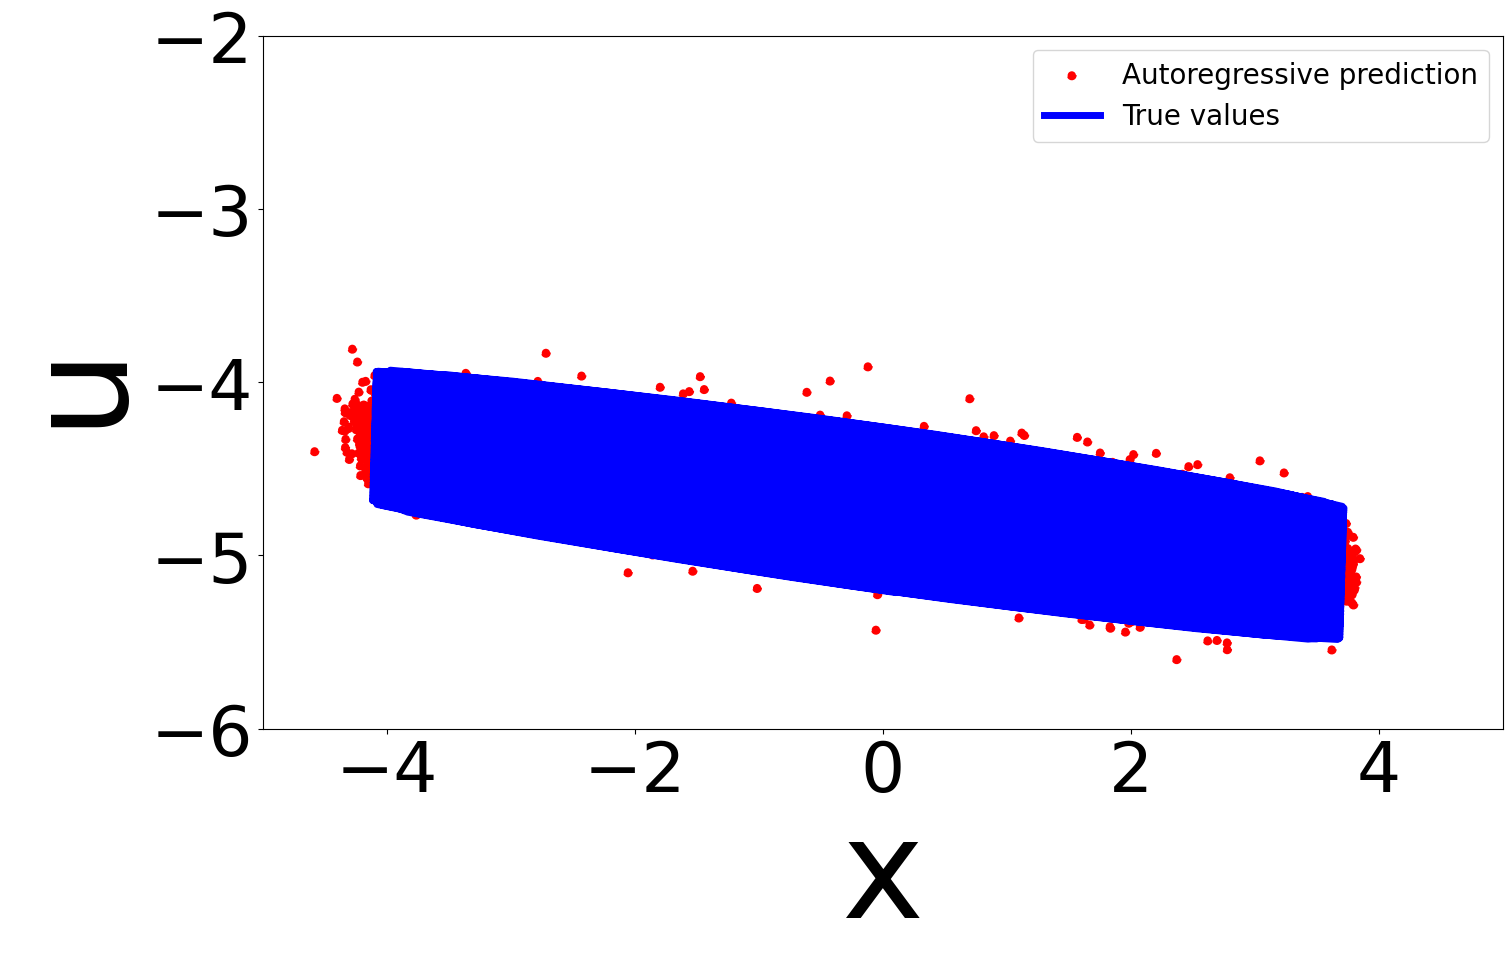

In [11]:
Plot(attractor1_preds, attractor1[:, ::10], axes=[0, 3], title="Train without noize first attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

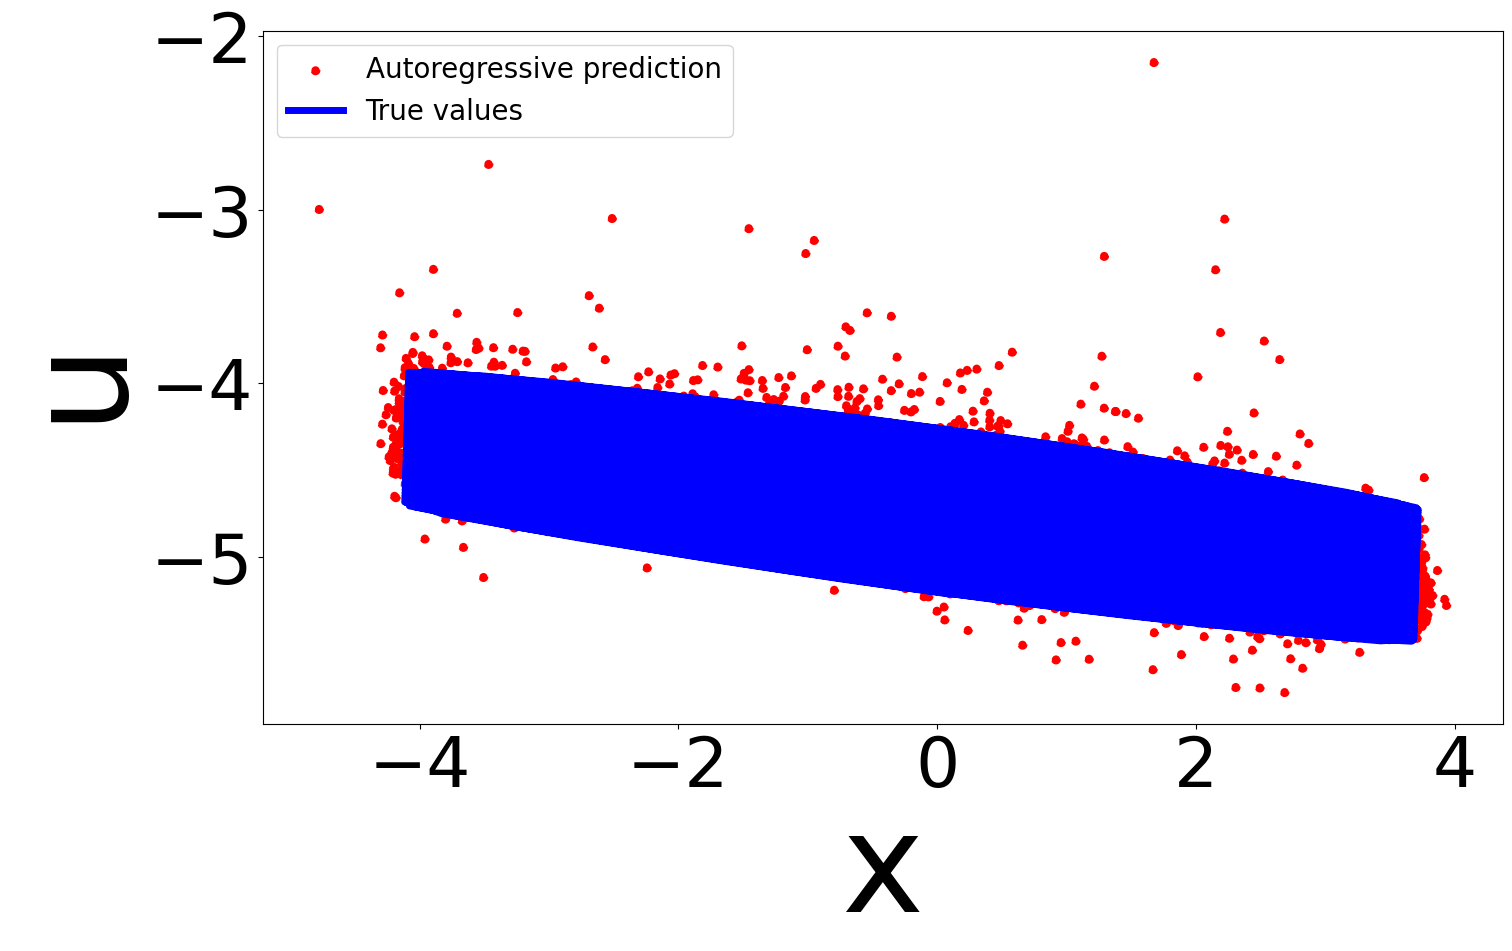

In [11]:
Plot(attractor1_preds, attractor1[:, ::10], axes=[0, 3], title="Train without noize first attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

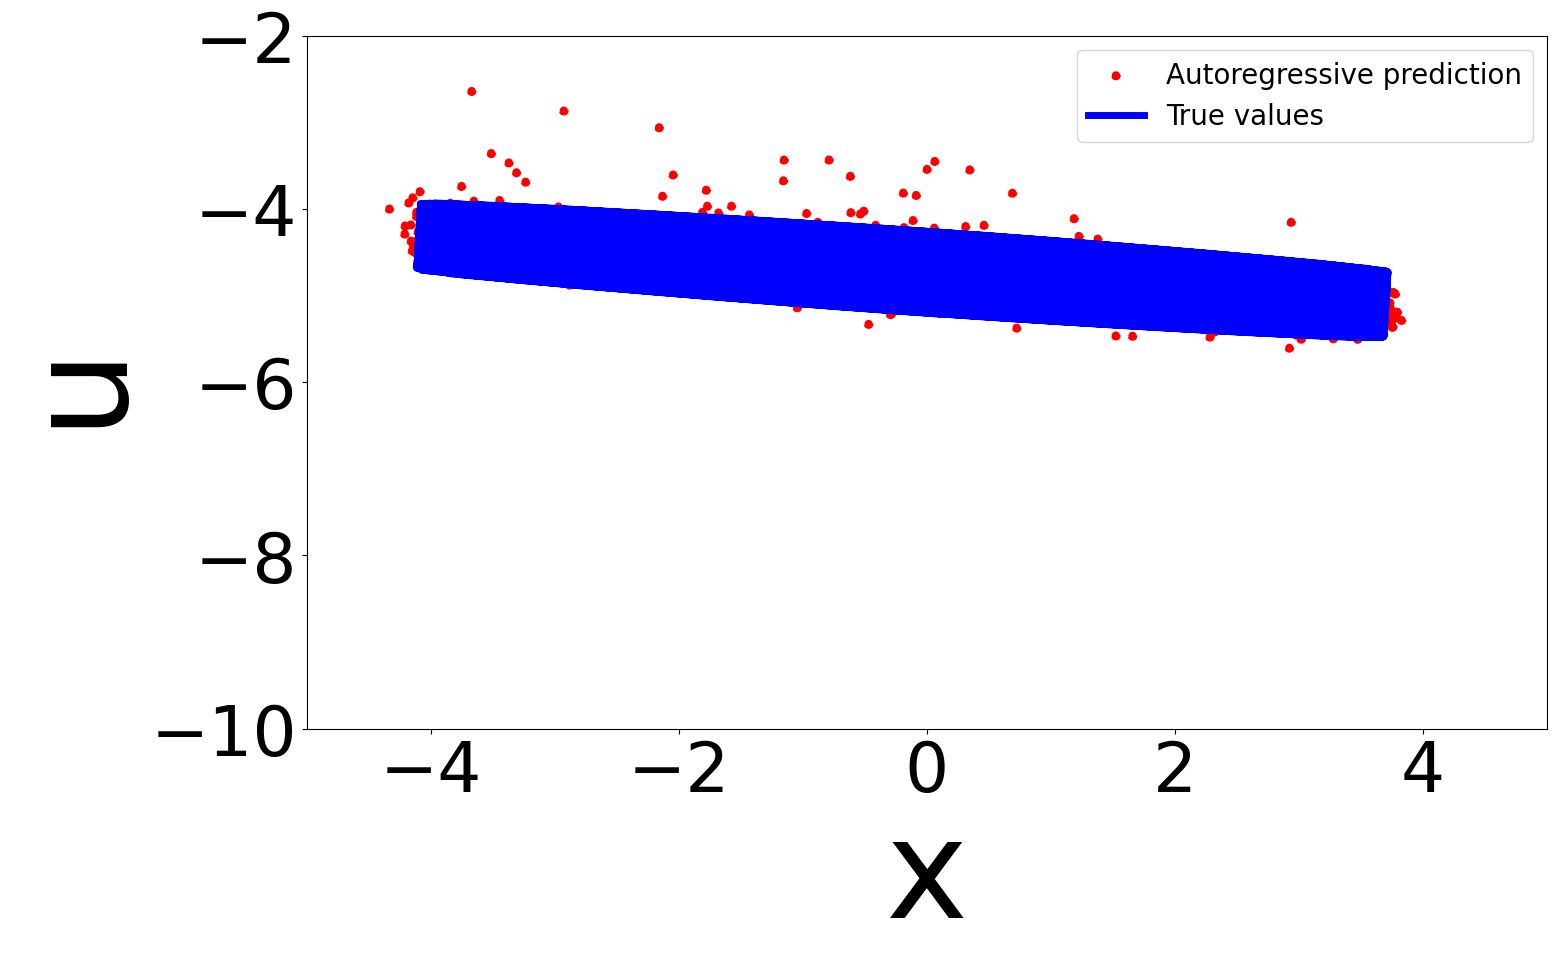

In [16]:
attractor1_preds = ReservoirPredict(attractor1_2.T[::10], reservoir)
Plot(attractor1_preds, attractor1[:, ::10], axes=[0, 3], title="Train without noize first attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

In [ ]:
attractor1_preds = ReservoirPredict(attractor1_3.T[::10], reservoir)

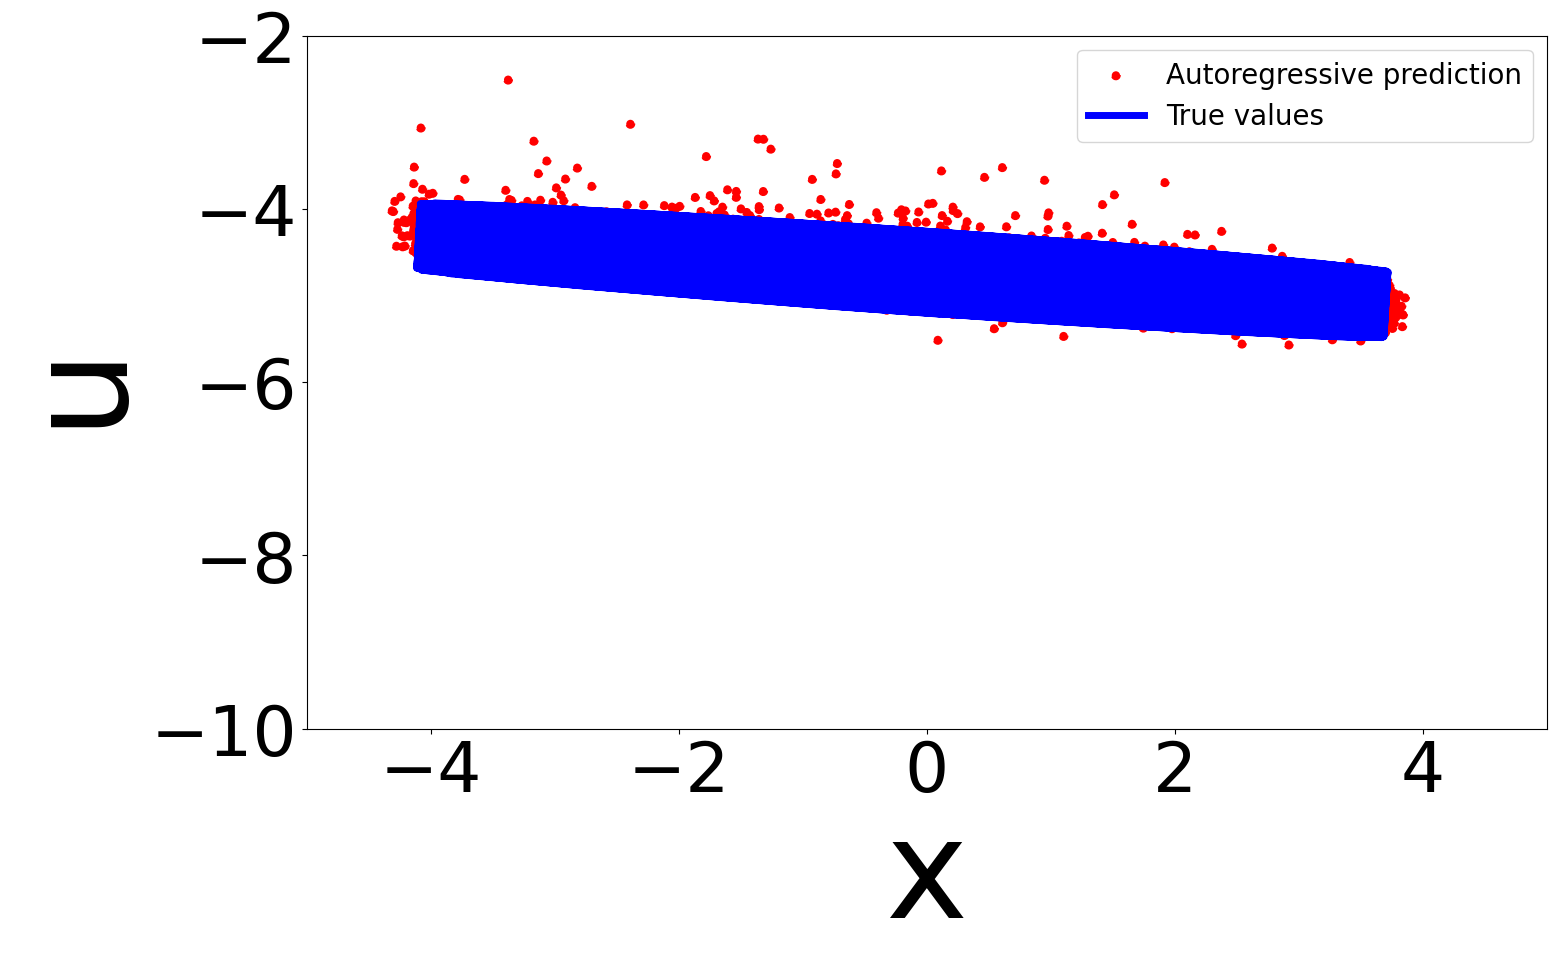

In [15]:
Plot(attractor1_preds, attractor1[:, ::10], axes=[0, 3], title="Train without noize first attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")


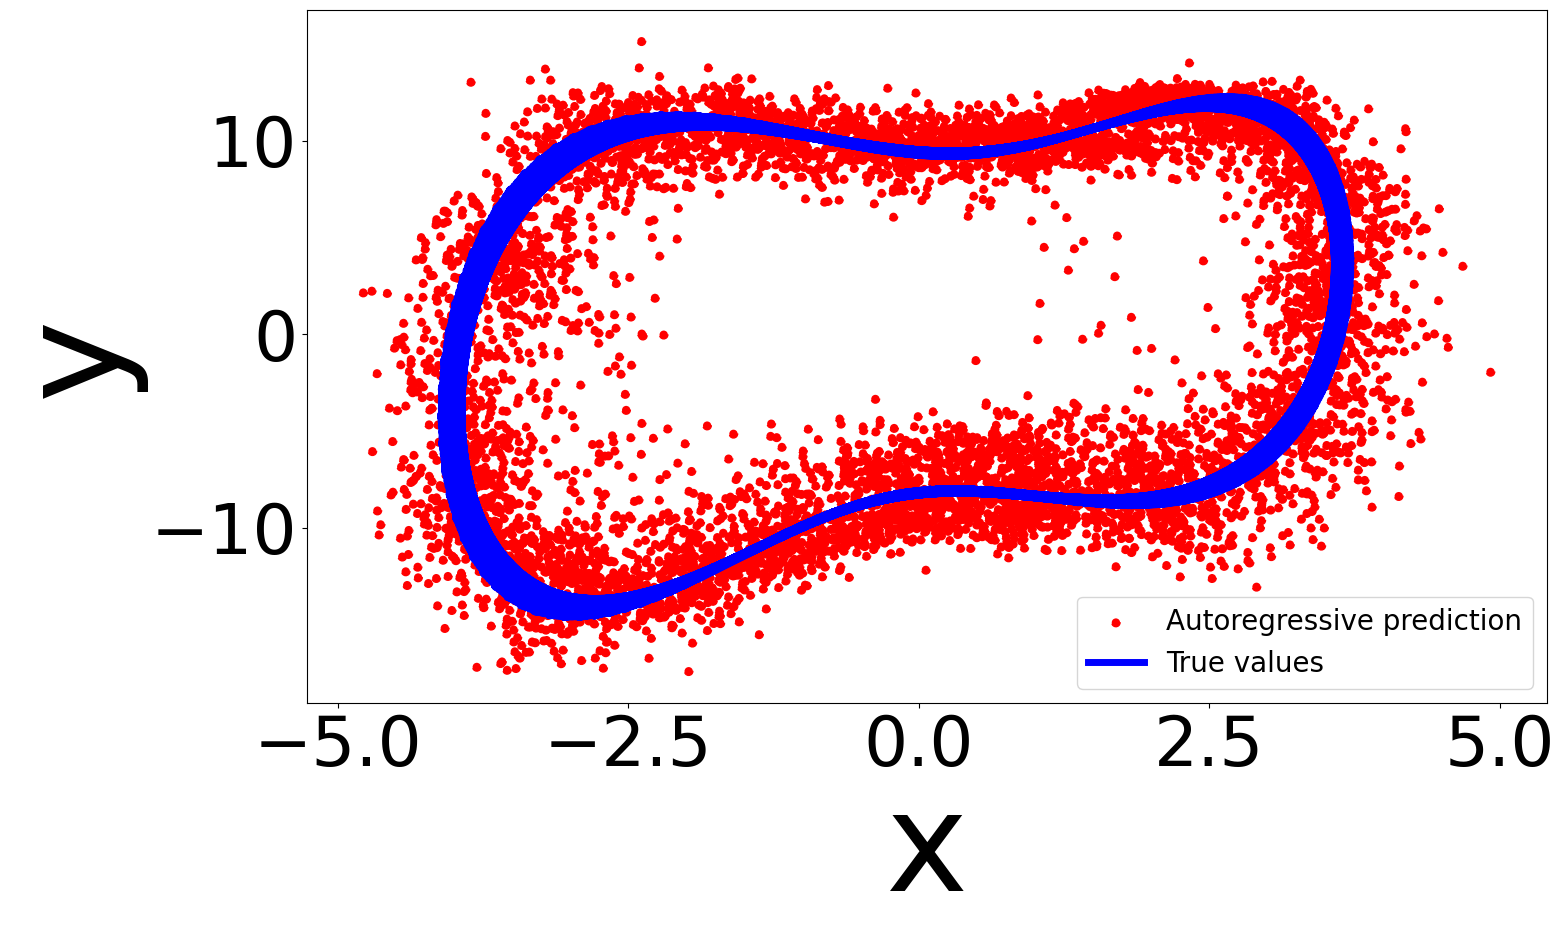

In [22]:
Plot(attractor1_preds, attractor1[:, ::10], title="Train  noize new dt first attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

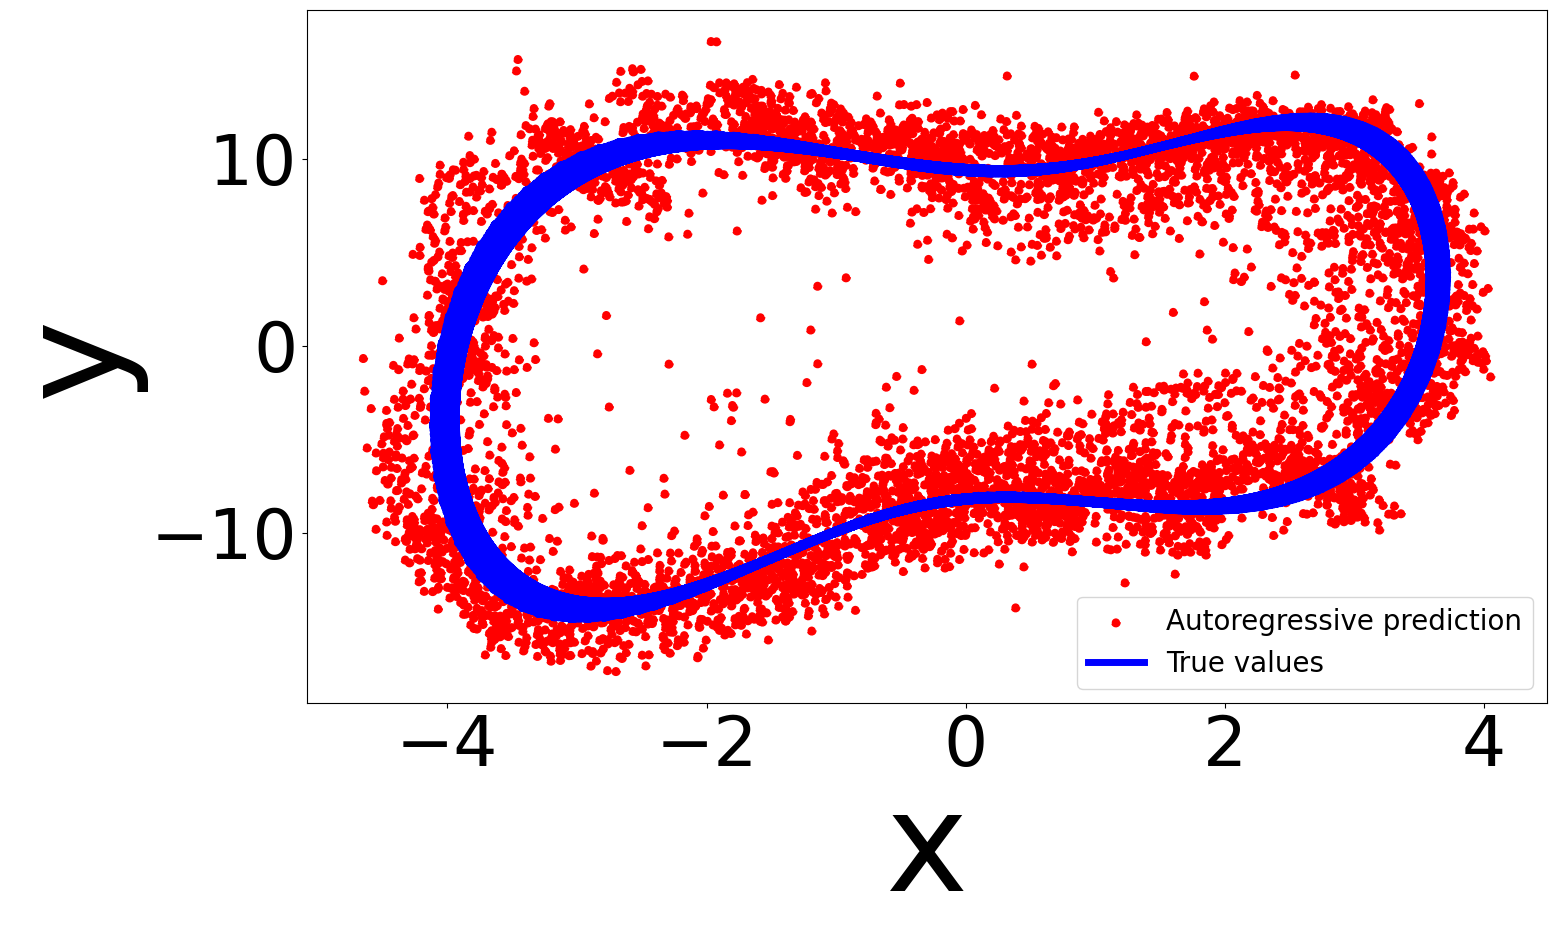

In [ ]:
Plot(attractor1_preds, attractor1[:, ::10], title="Train without noize first attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

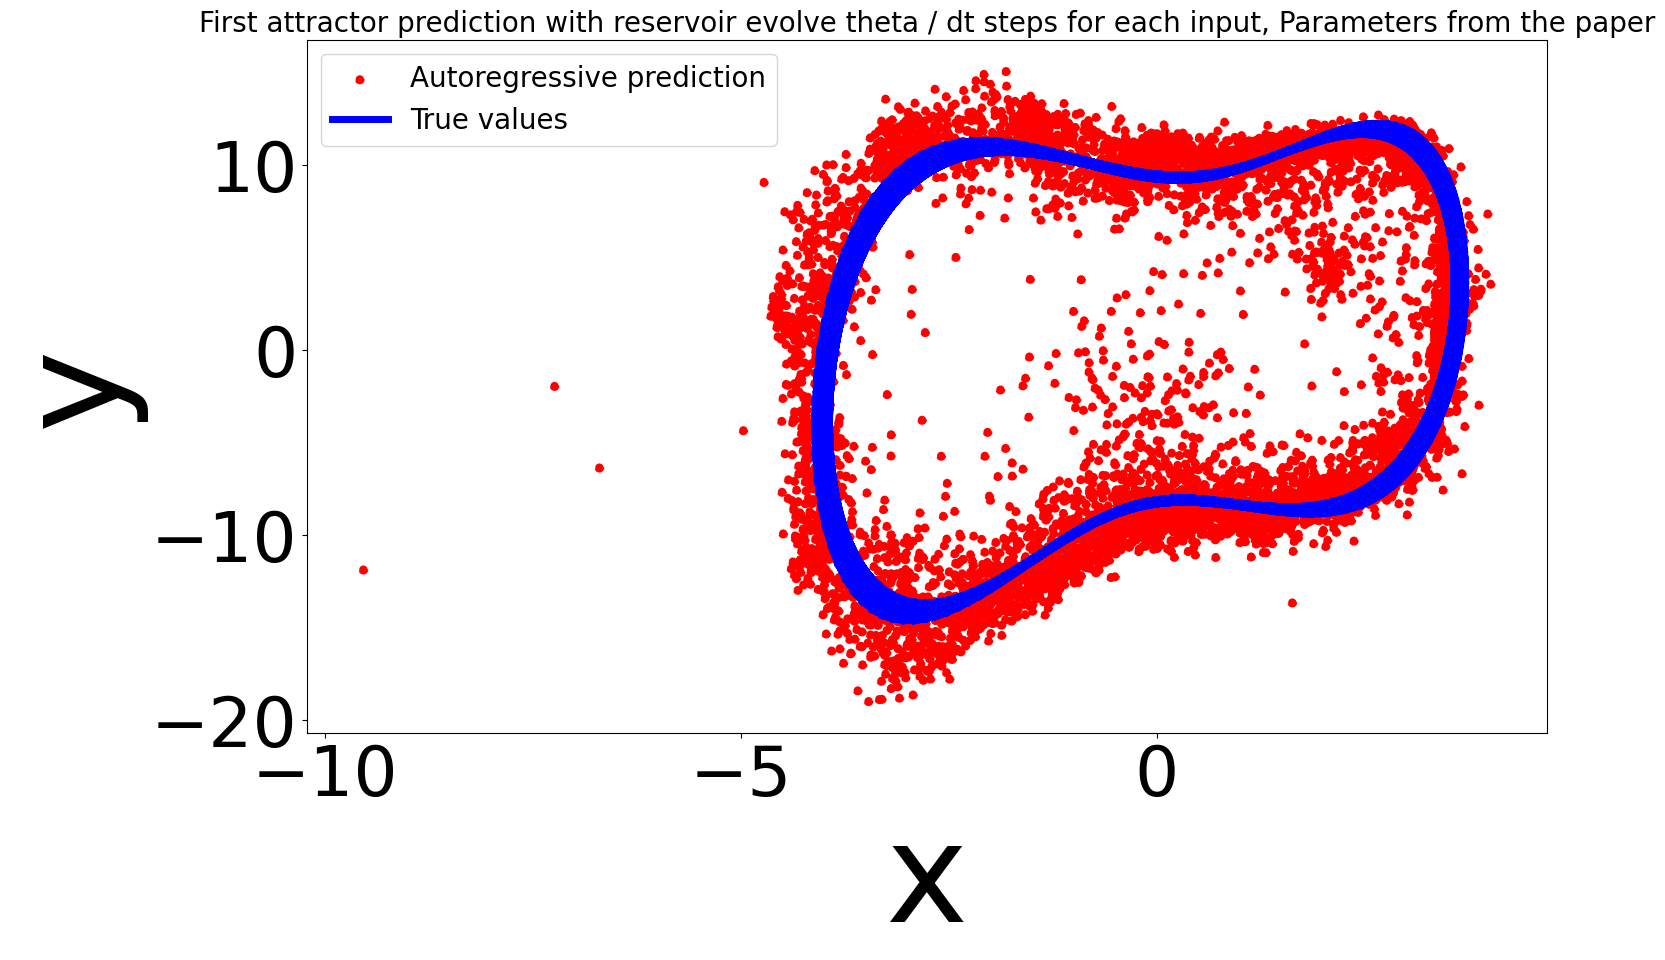

In [94]:
Plot(attractor1_preds, attractor1[:, ::10], title="First attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

In [16]:
input_sequence.shape

(10000, 4)

In [18]:
attractor1_preds.shape

(7499, 1, 4)

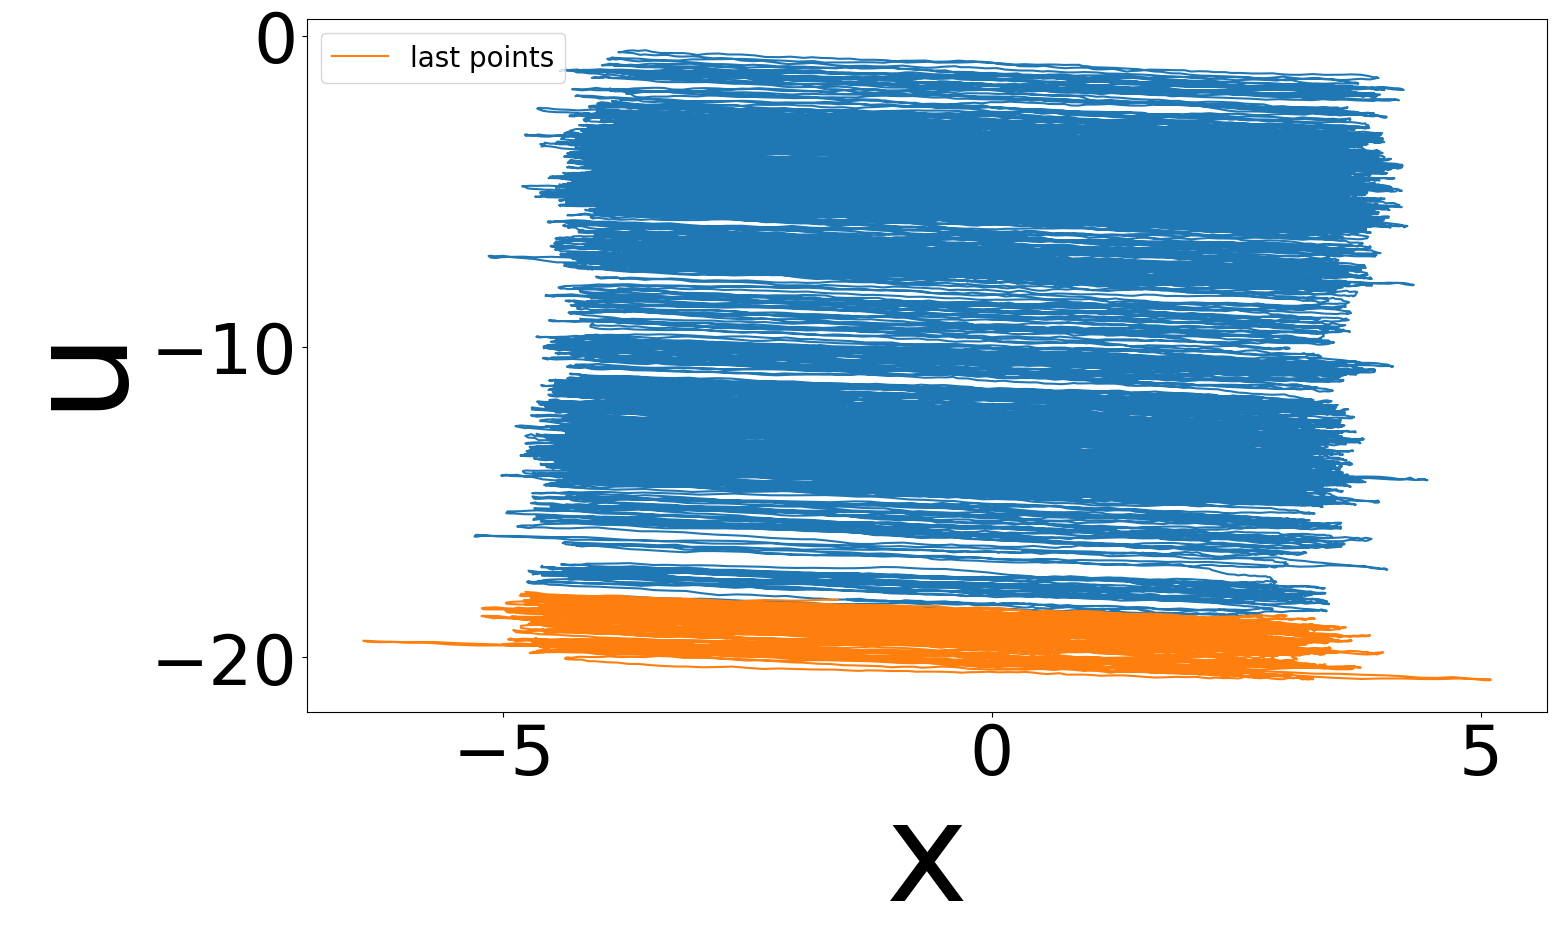

In [4]:
plt.figure(figsize=(16, 9))
plt.plot(trajectorys[2][:90000, 0], trajectorys[2][:90000, 3])

plt.plot(trajectorys[2][90000:, 0], trajectorys[2][90000:, 3], label="last points")
plt.xlabel("x", size=100)
plt.ylabel("u", size=100)
plt.tick_params(axis='both', which='major', labelsize=50)
plt.legend(fontsize=20)

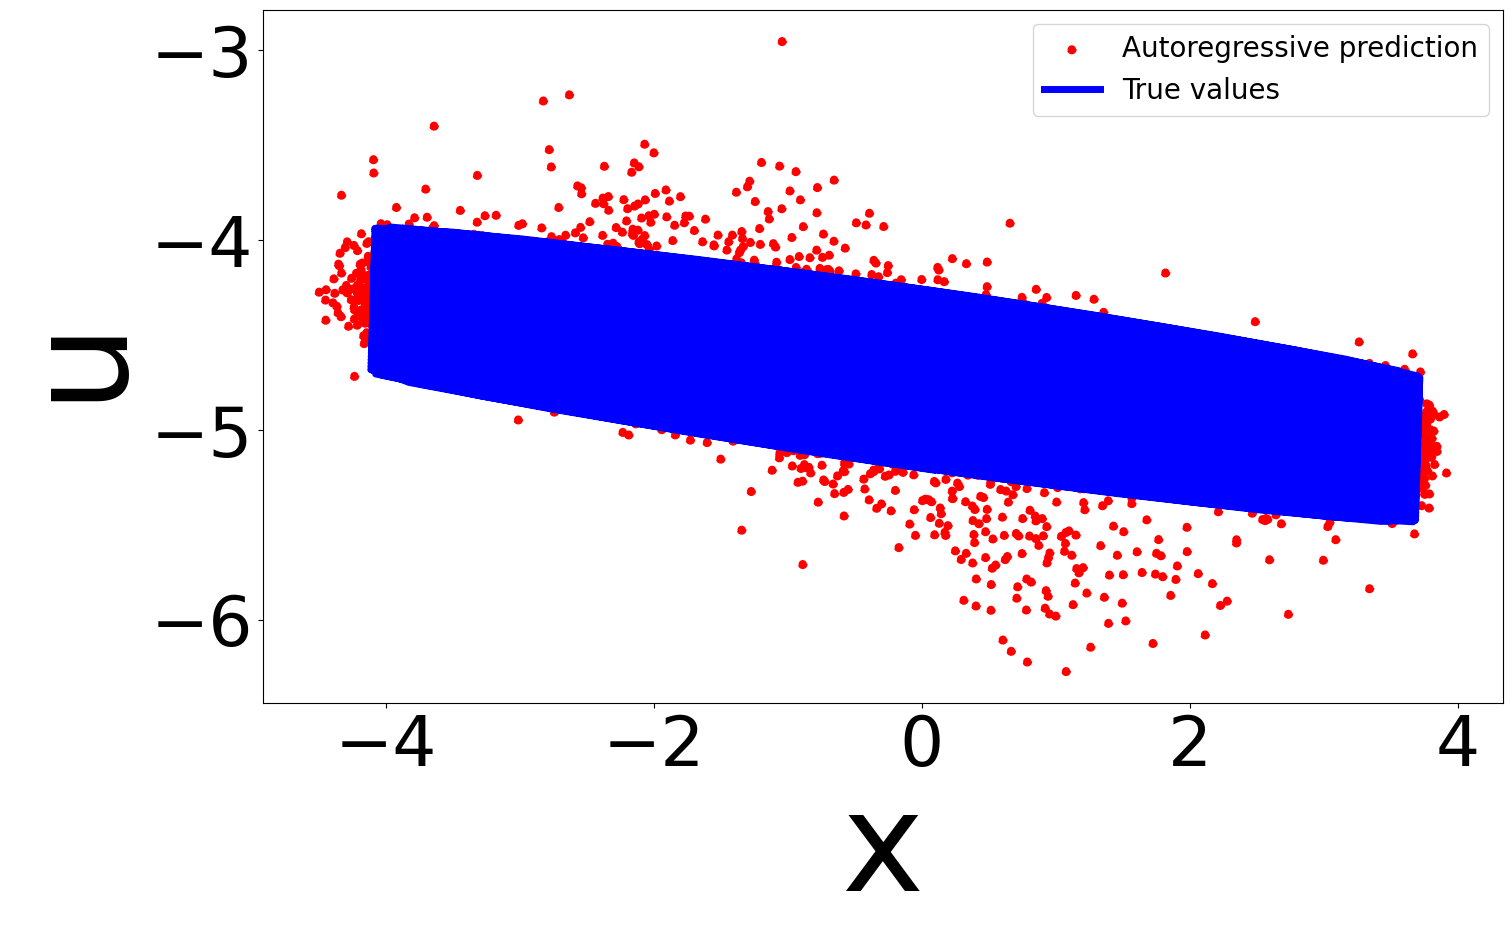

In [ ]:
Plot(attractor1_preds, attractor1[:, ::10], axes=[0, 3], title="Train without noize first attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

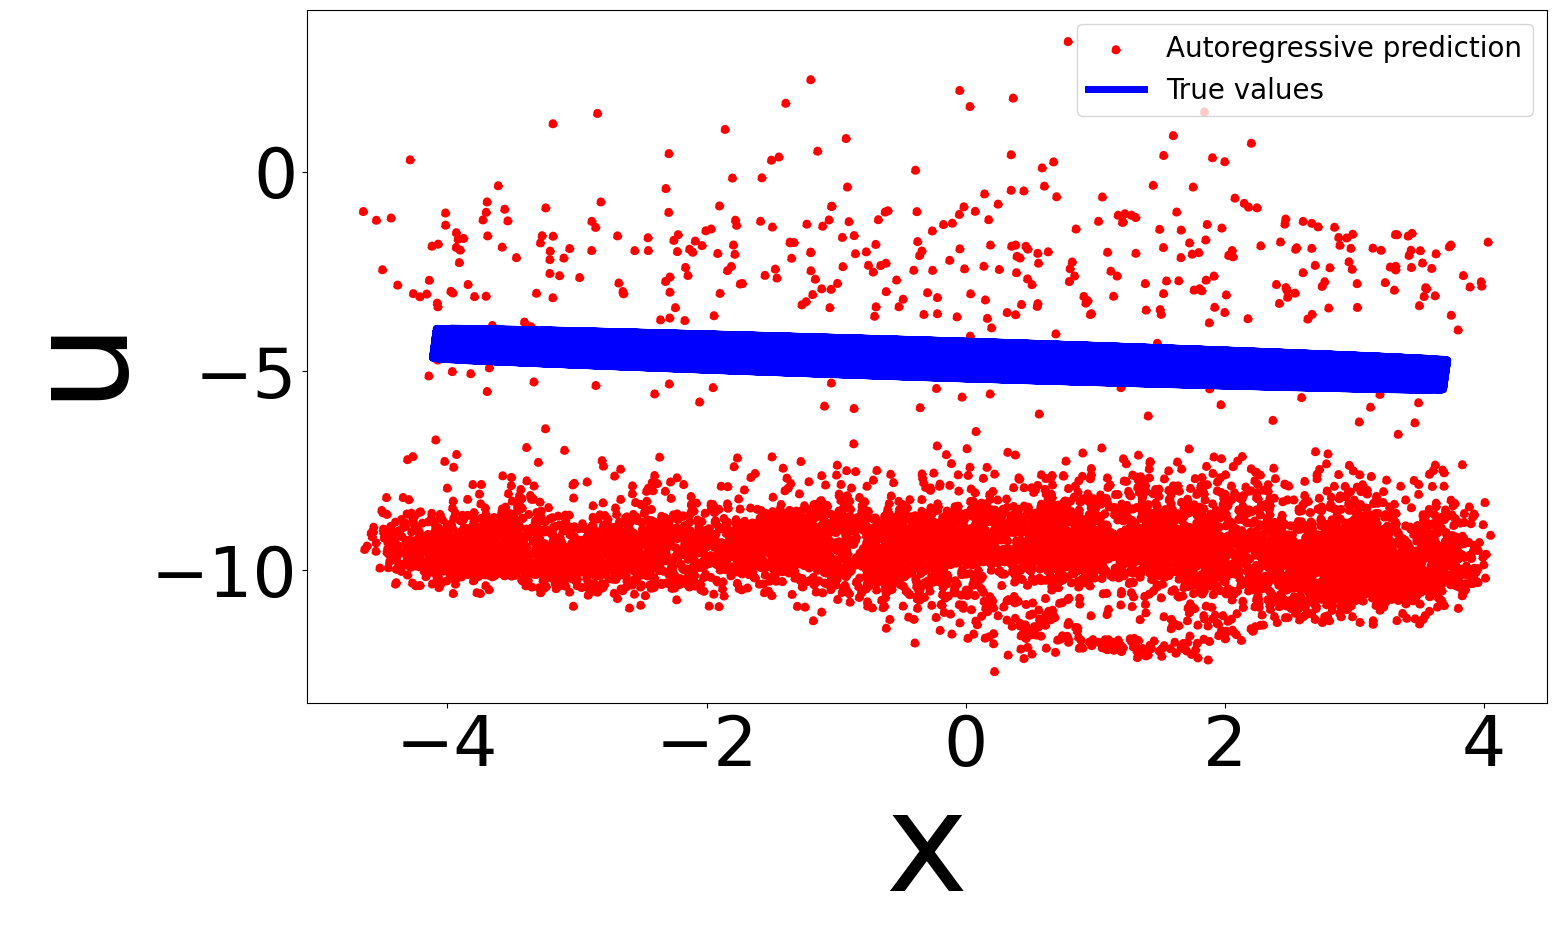

In [33]:
Plot(attractor1_preds, attractor1[:, ::10], axes=[0, 3], title="First attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

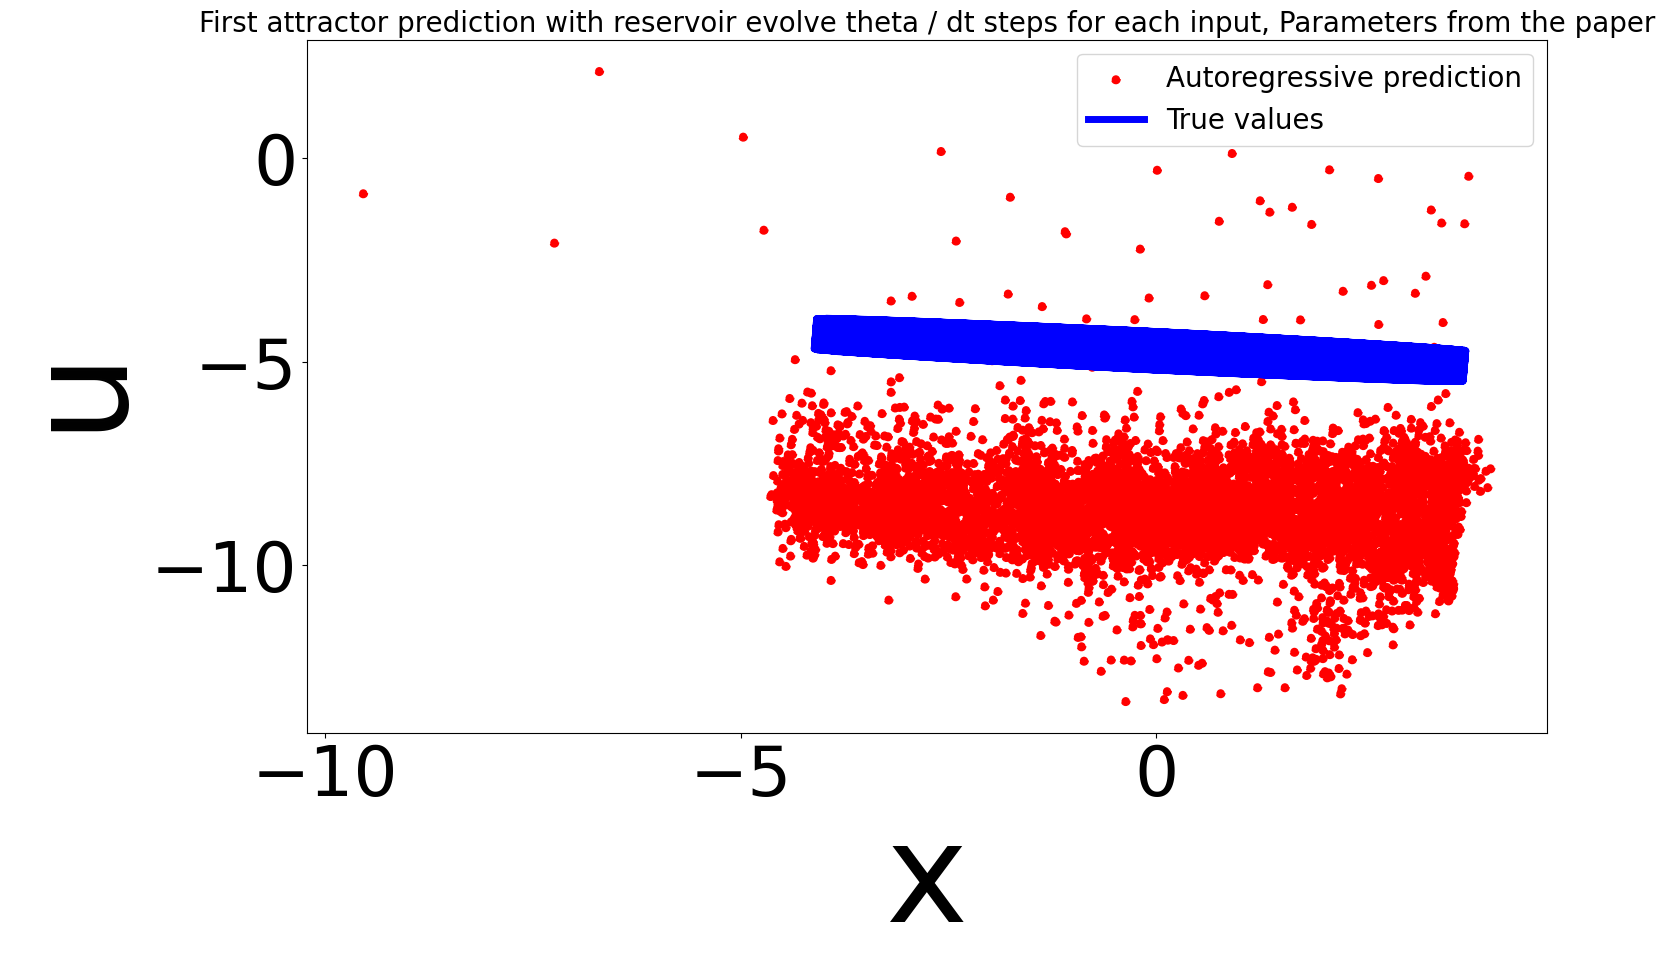

In [95]:
Plot(attractor1_preds, attractor1[:, ::10], axes=[0, 3], title="First attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

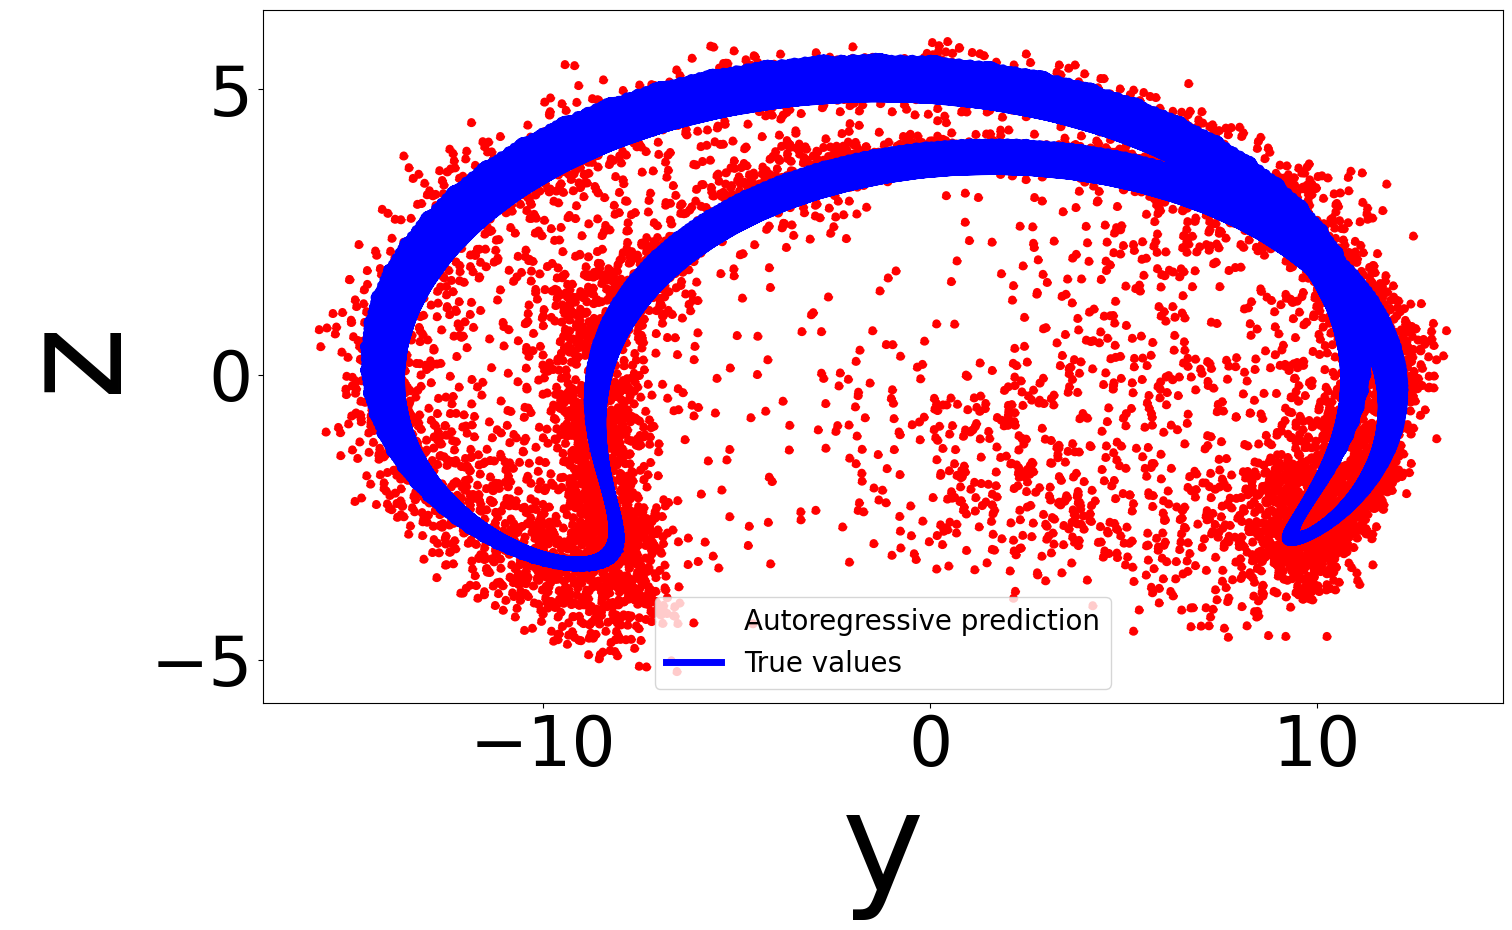

In [ ]:
Plot(attractor1_preds, attractor1[:, ::10], axes=[1, 2], title="Train without noize first attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

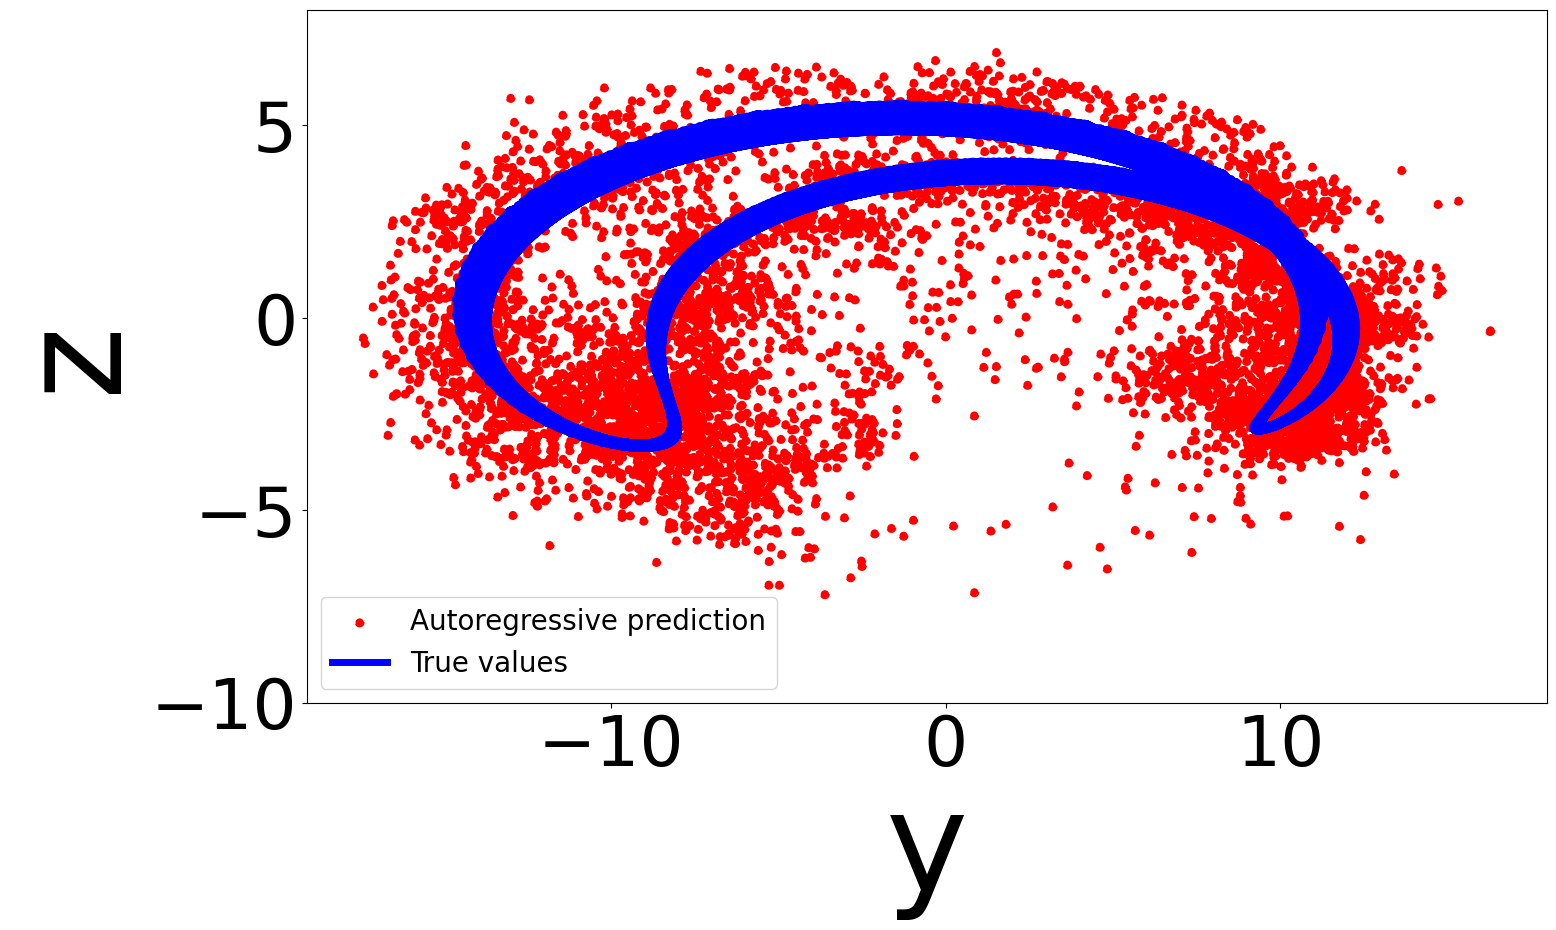

In [36]:
Plot(attractor1_preds, attractor1[:, ::10], axes=[1, 2], title="First attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

In [38]:
attractor2_preds = ReservoirPredict(attractor2.T[::10], reservoir)

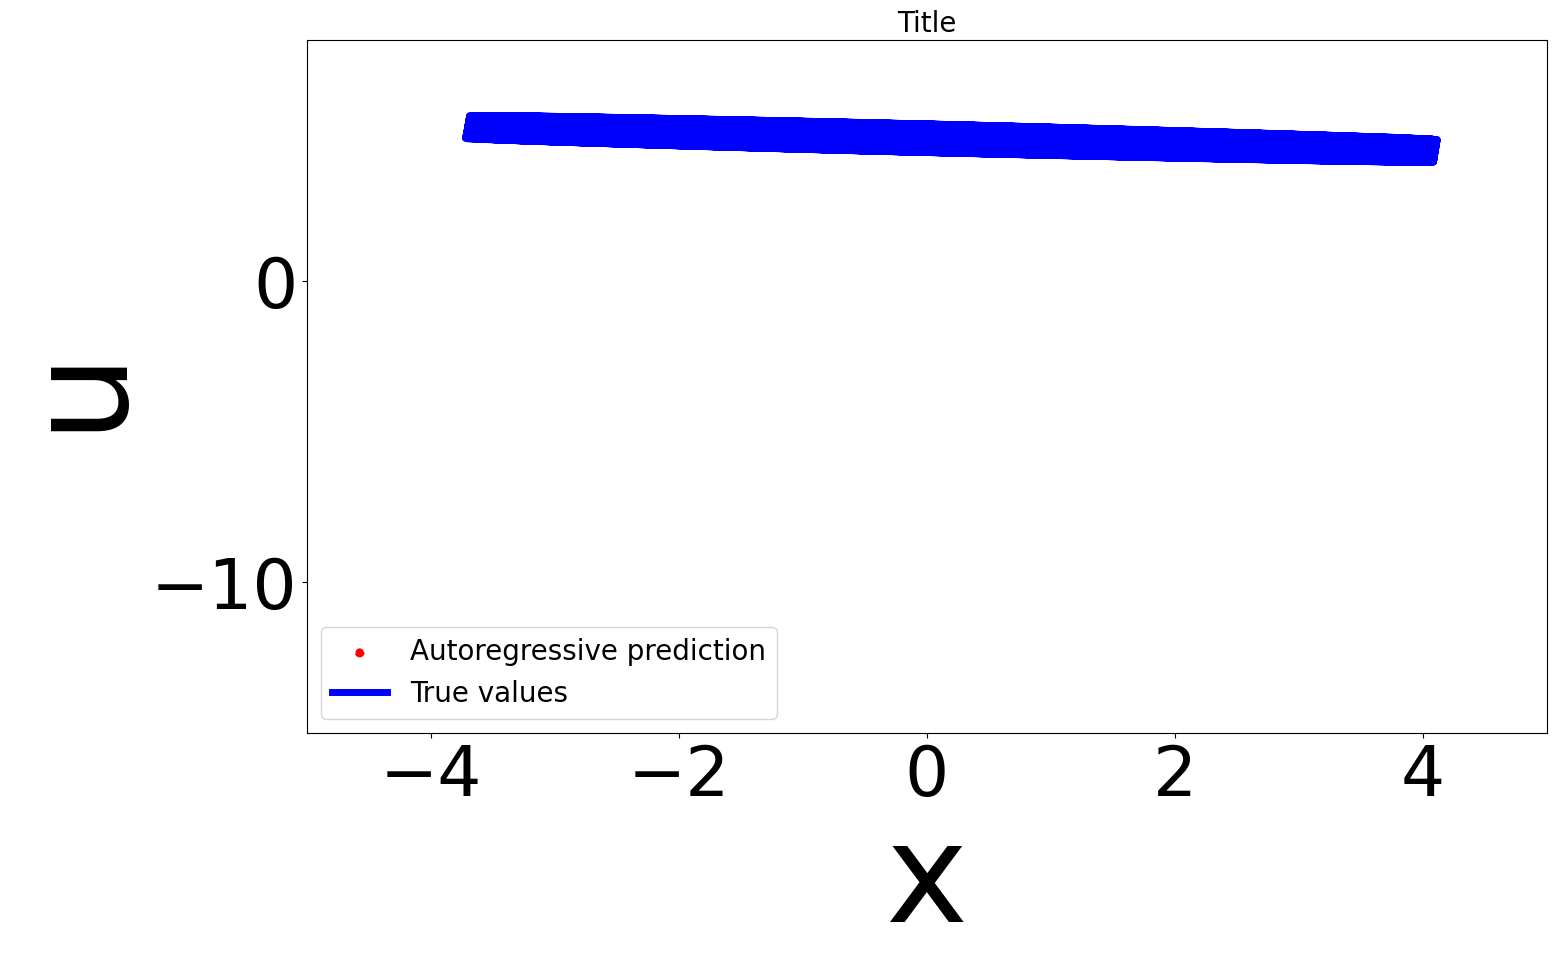

In [21]:
Plot(attractor2_preds, attractor2[:, ::10], axes=[0, 3])

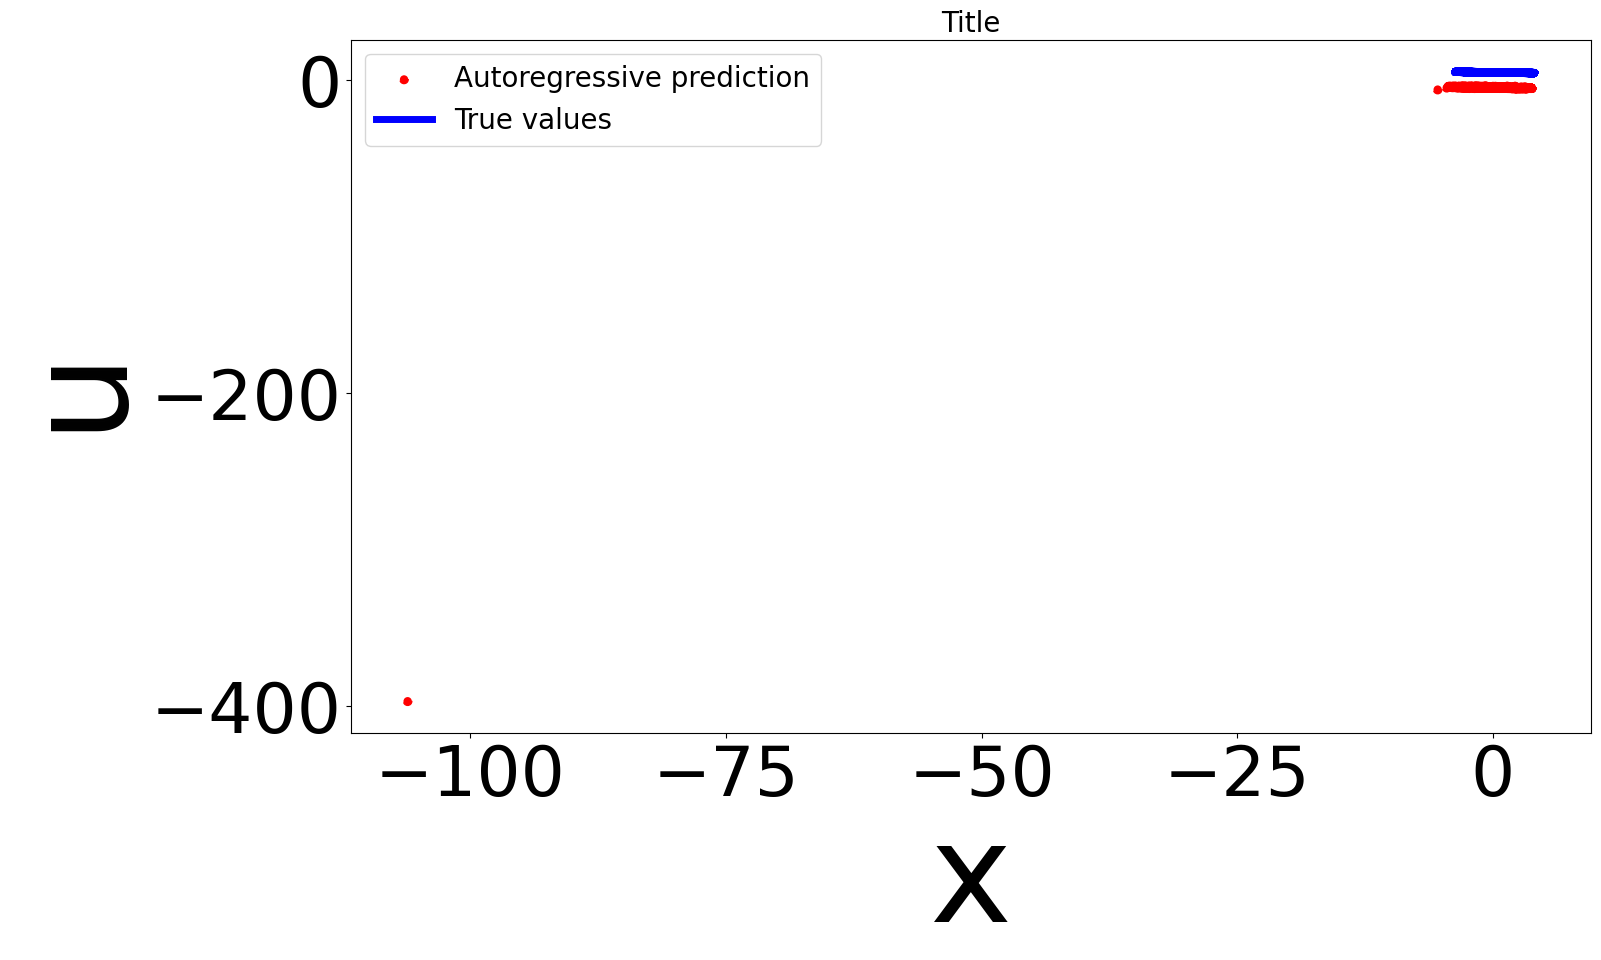

In [106]:
Plot(attractor2_preds, attractor2[:, ::10], axes=[0, 3])


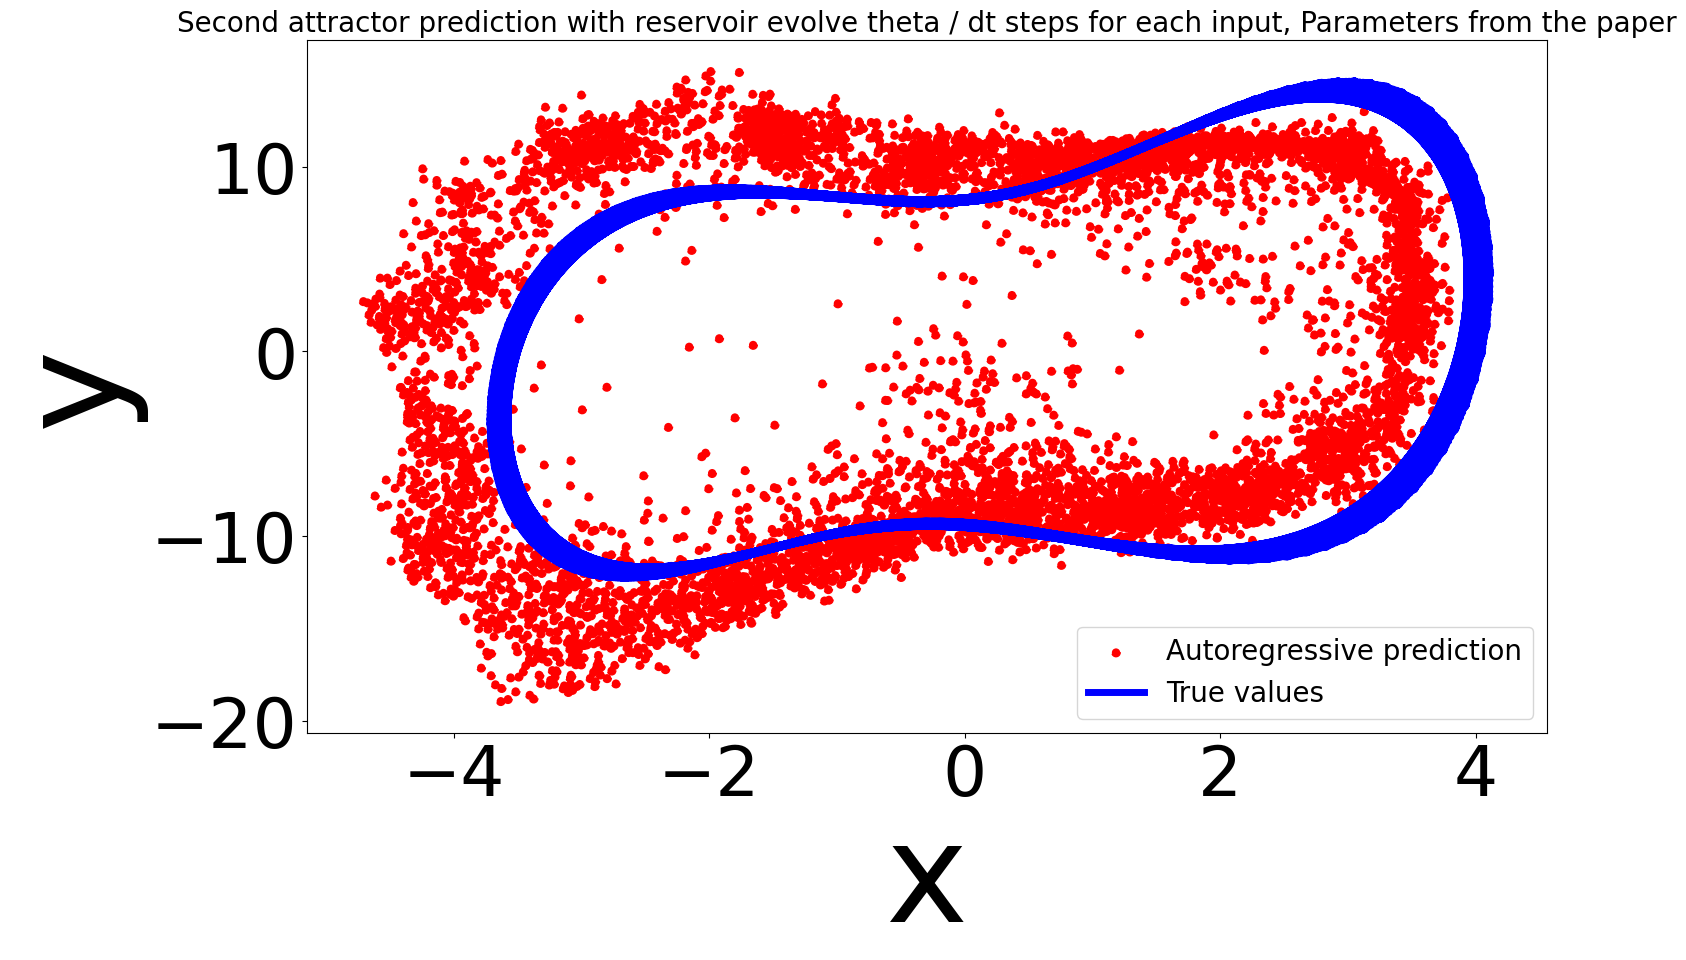

In [88]:
Plot(attractor2_preds, attractor2[:, ::10], title="Second attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")


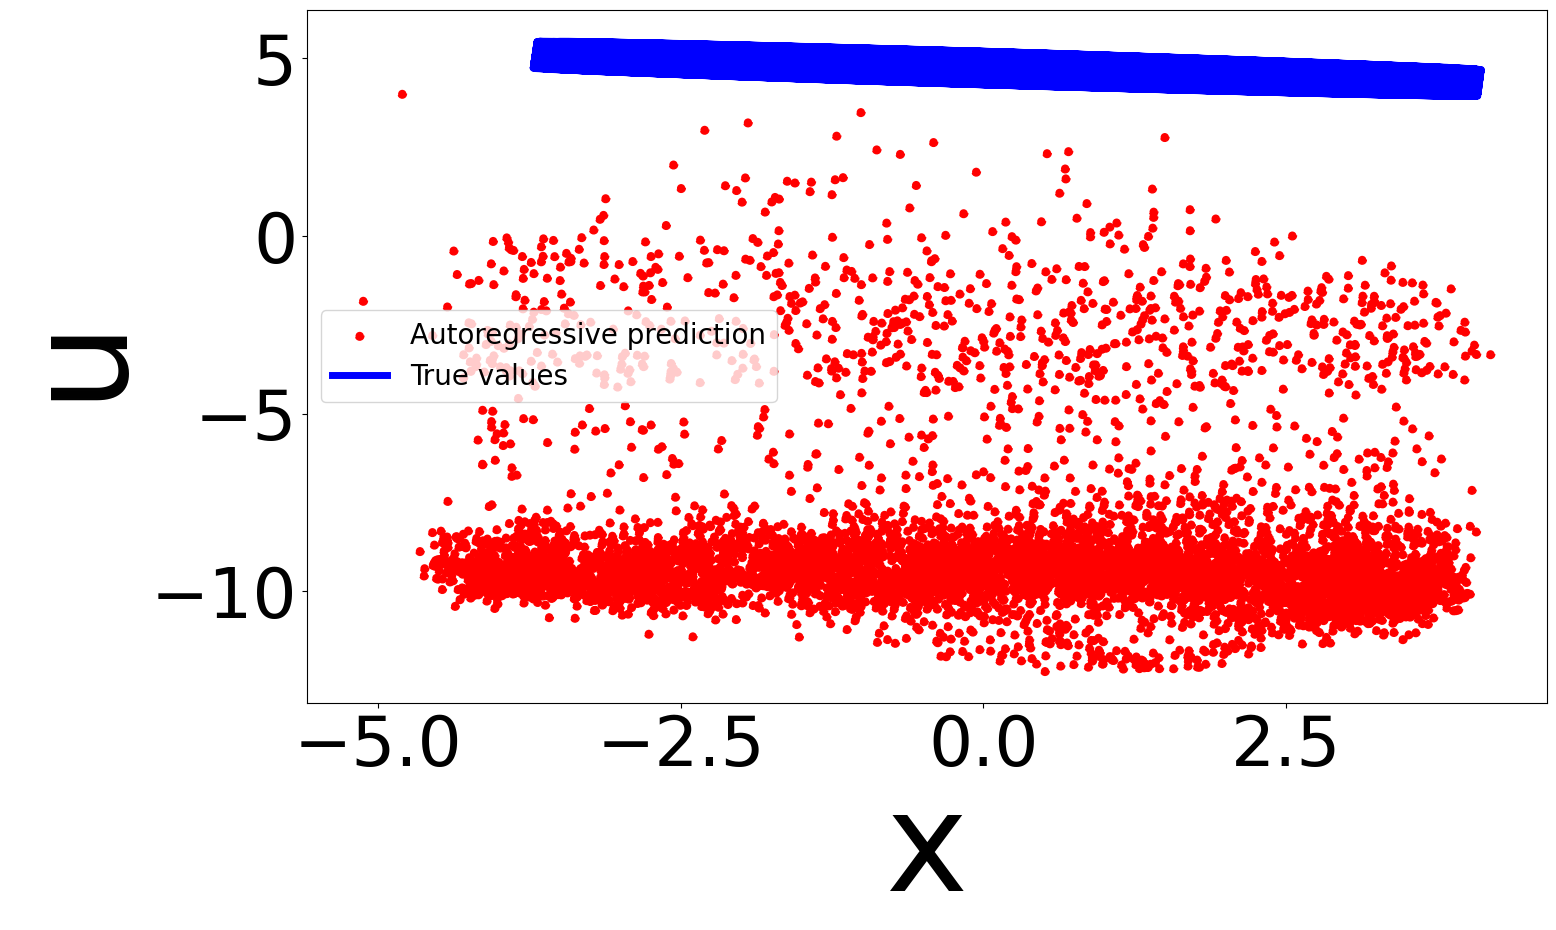

In [39]:
Plot(attractor2_preds, attractor2[:, ::10], axes=[0, 3], title="Second attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")


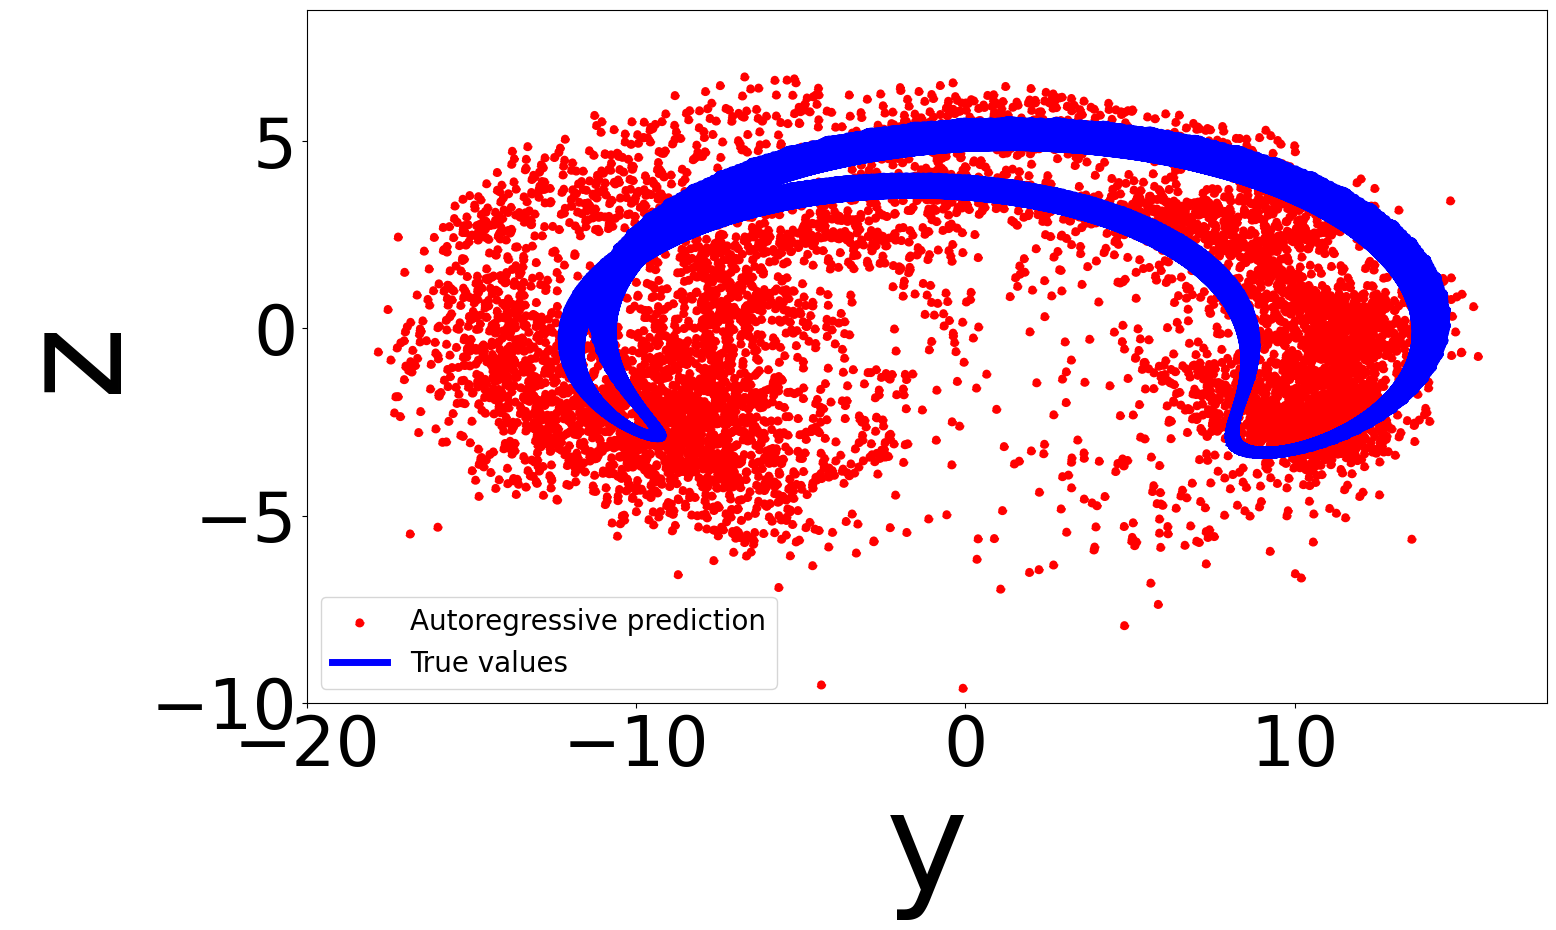

In [42]:
Plot(attractor2_preds, attractor2[:, ::10], axes=[1, 2], title="Second attractor prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")


In [43]:
thorus_preds = ReservoirPredict(thorus.T[::10], reservoir)


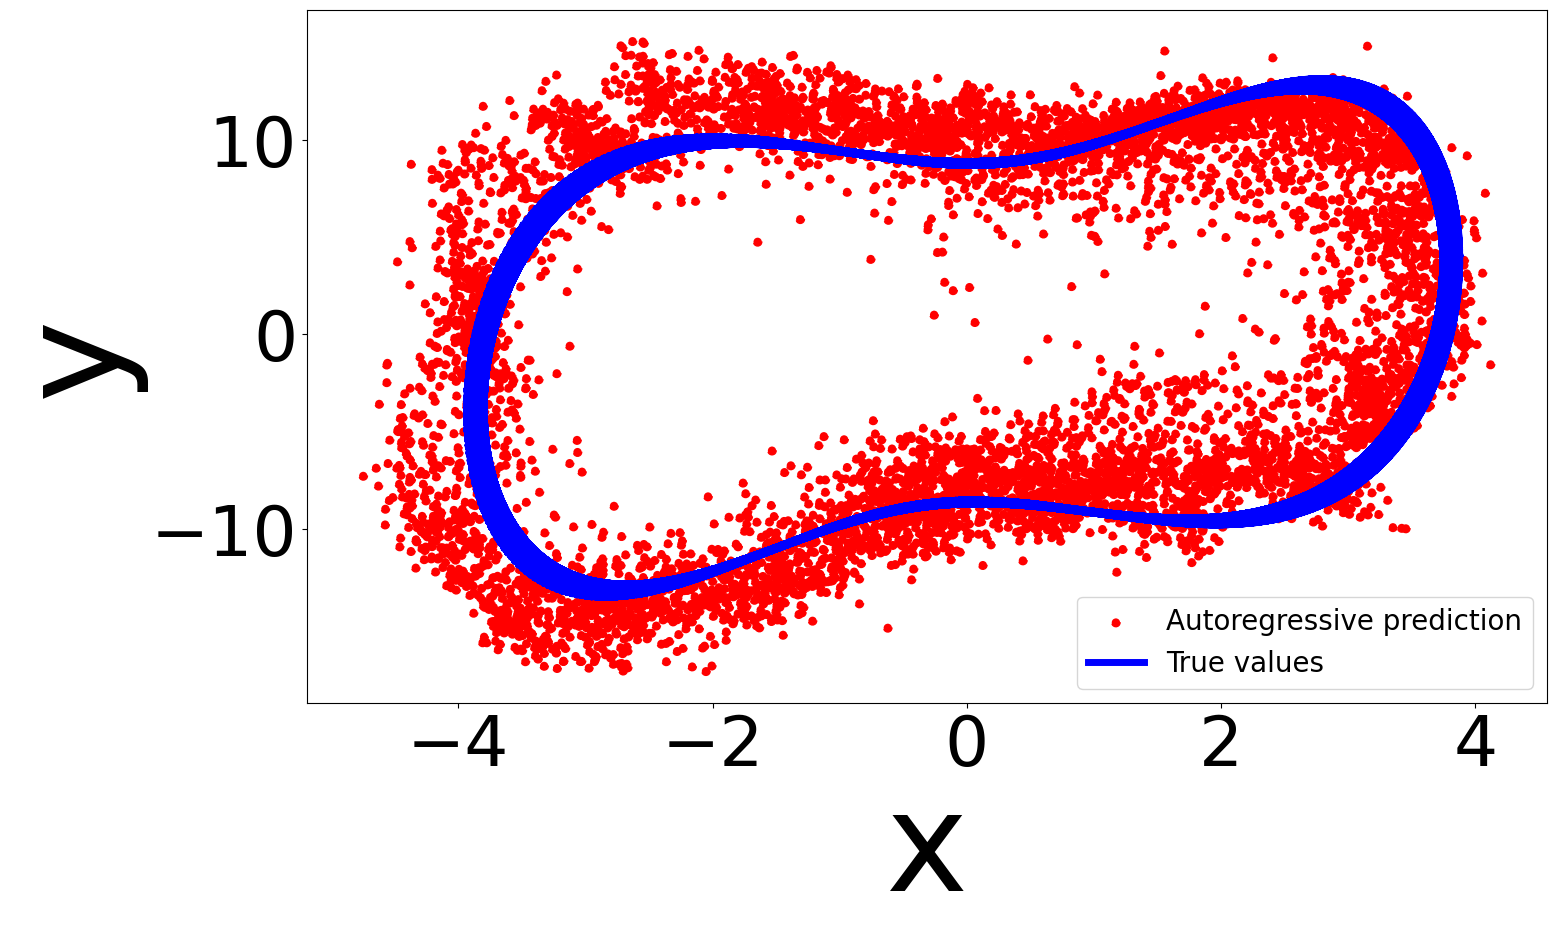

In [45]:
Plot(thorus_preds, thorus[:, ::10])

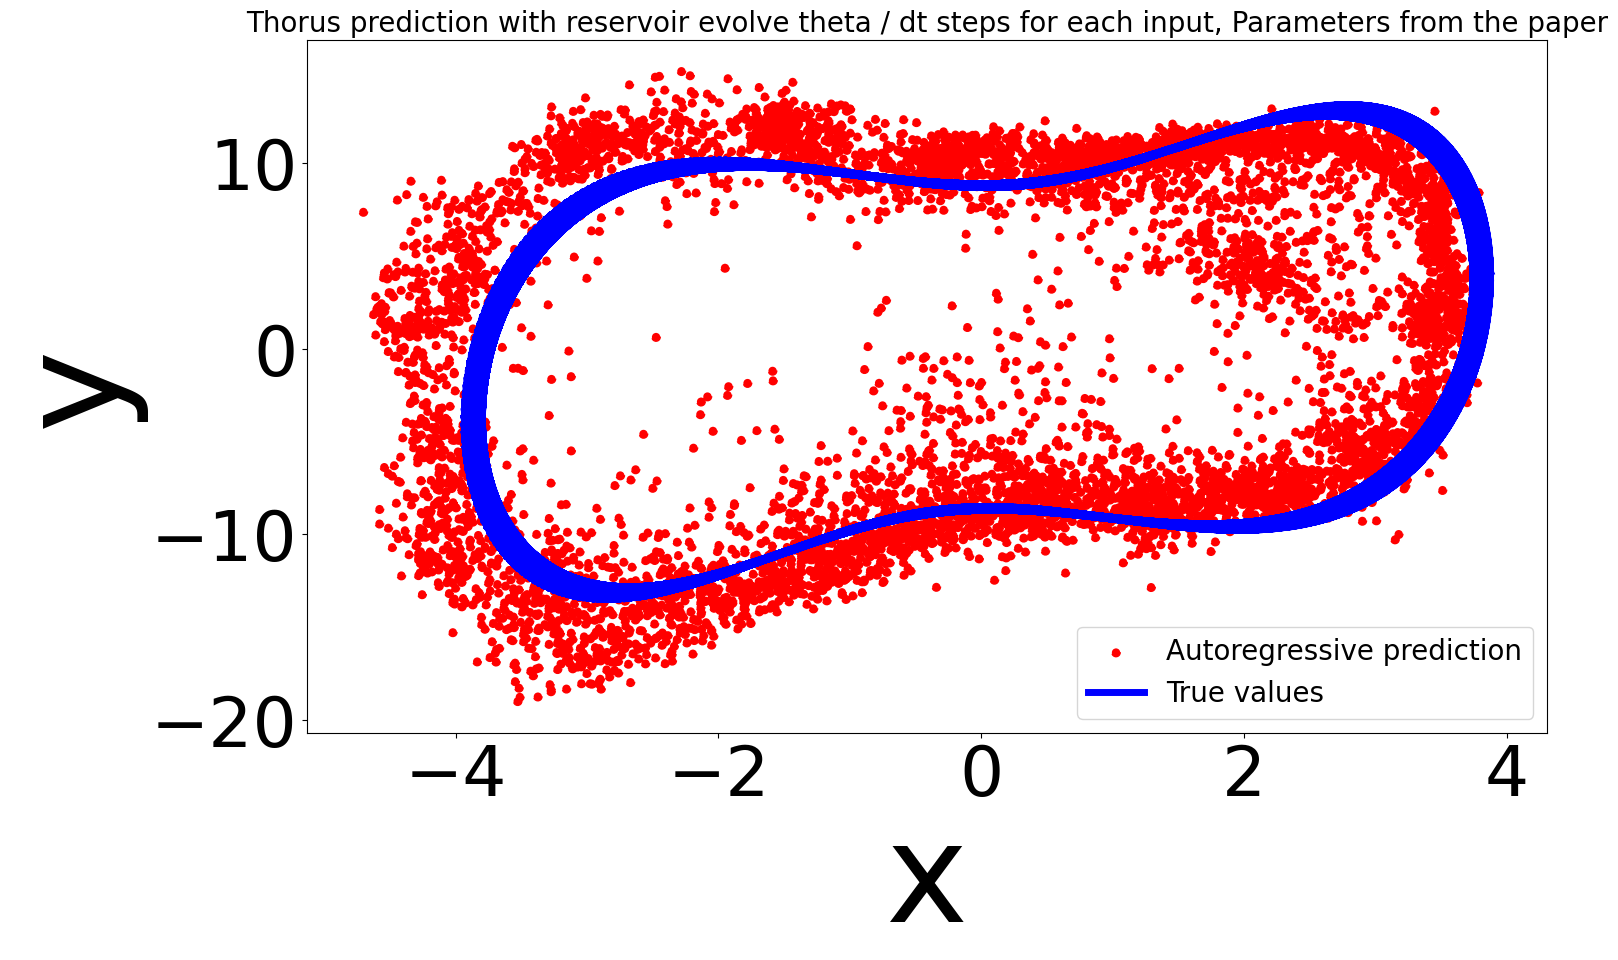

In [91]:
Plot(thorus_preds, thorus[:, ::10], title="Thorus prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

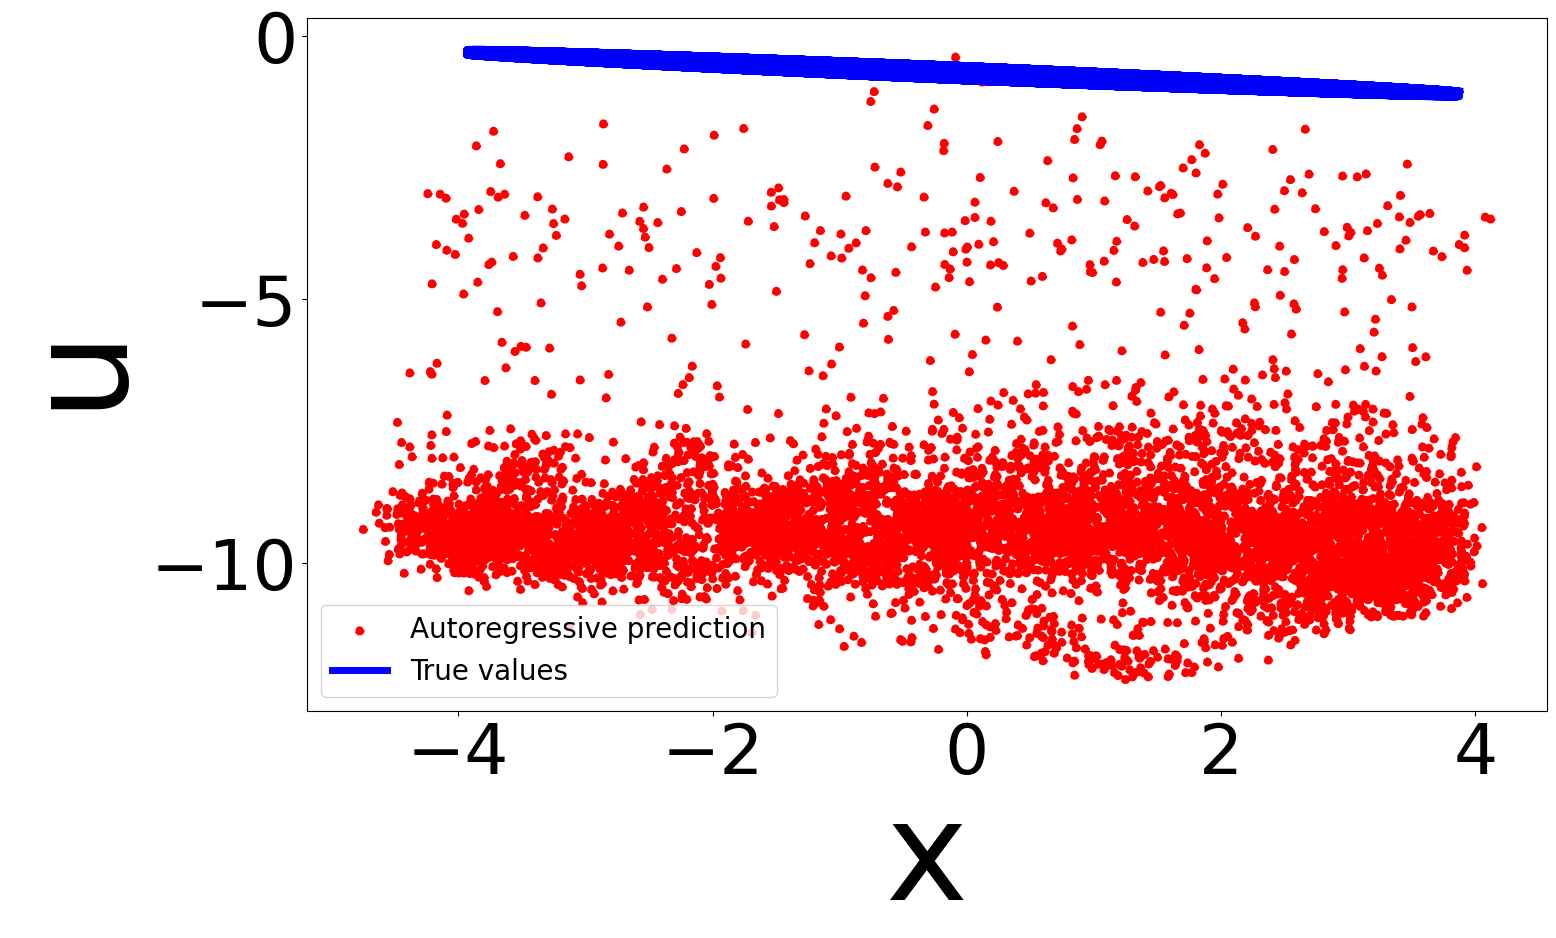

In [46]:
Plot(thorus_preds, thorus[:, ::10], axes=[0, 3], title="Thorus prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

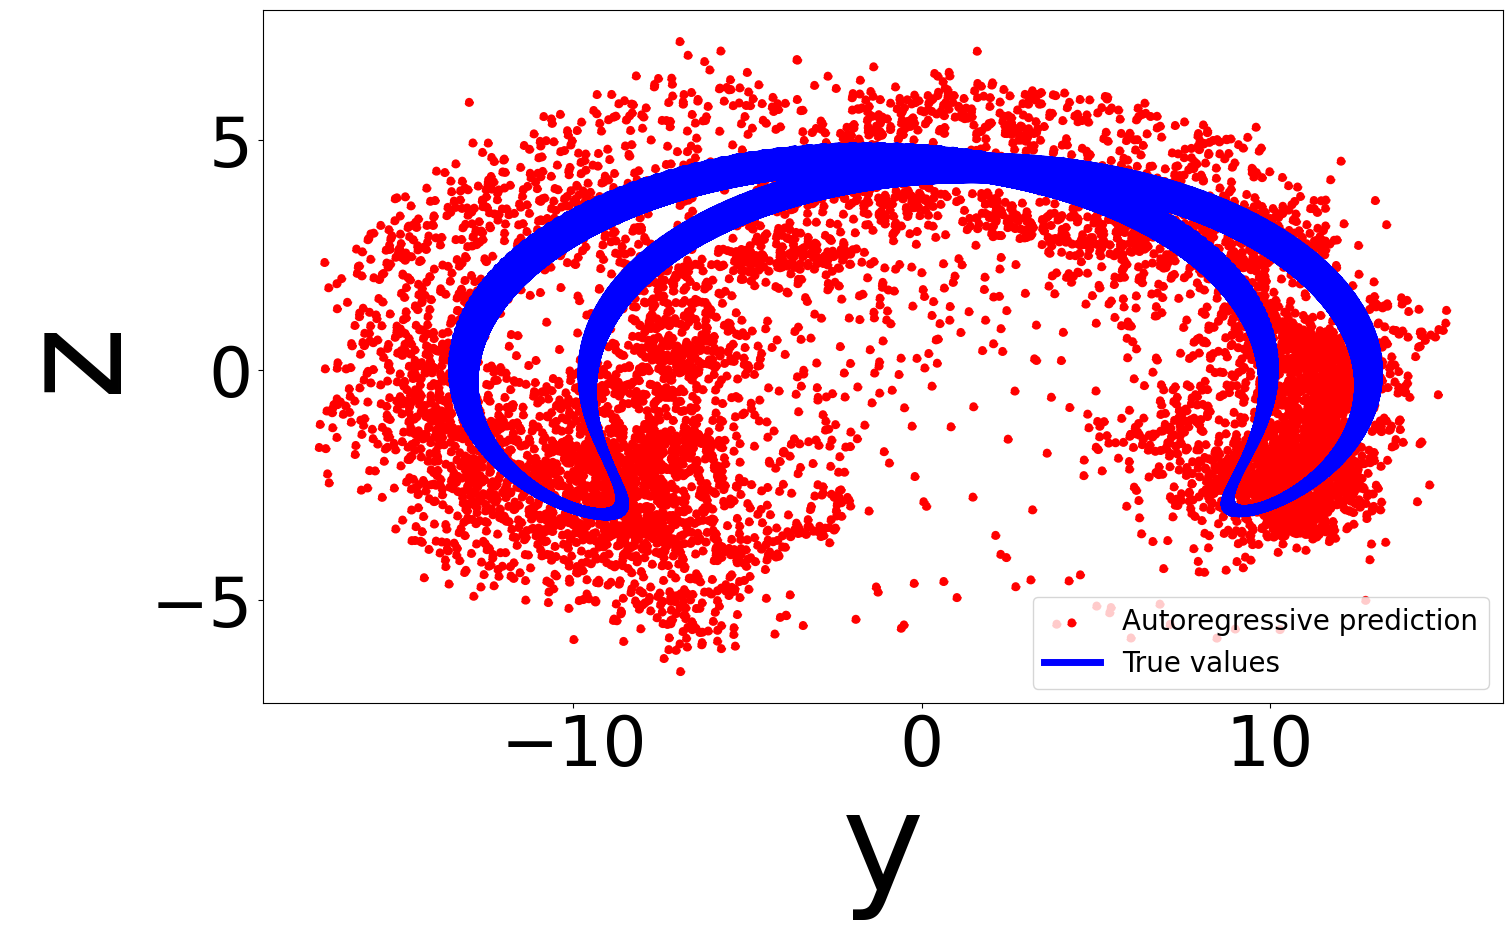

In [47]:
Plot(thorus_preds, thorus[:, ::10], axes=[1, 2], title="Thorus prediction with reservoir evolve theta / dt steps for each input, Parameters from the paper")

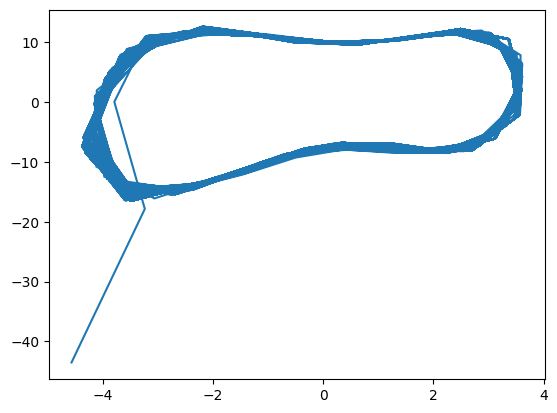

In [40]:
plt.plot(thorus_preds[:, :, 0], thorus_preds[:, :, 1])


# Reservoir parameters from paper

In [ ]:
import numpy as np
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir

# Создаем пользовательский класс Reservoir с методом Рунге-Кутта 4-го порядка
class RK4Reservoir(Reservoir):
    def __init__(self, units, input_gain, W, Win, bias):
        super().__init__(units=units, lr=lr, W=W, Win=Win, bias=bias)
        self.input_gain = input_gain
        self.bias = bias

    def _forward(self, u):
        # Получаем текущее состояние резервуара
        x = self.state()

        # Получаем параметры
        W_in = self.input_weights
        W_res = self.internal_weights
        G = self.input_gain
        B = self.bias

        # Функция динамики резервуара
        def f(x, u):
            return -x + np.tanh(W_res @ x + G * W_in @ u + B)

        # Шаг времени
        dt = 0.1

        # Метод Рунге-Кутта 4-го порядка
        k1 = f(x, u)
        k2 = f(x + 0.5 * dt * k1, u)
        k3 = f(x + 0.5 * dt * k2, u)
        k4 = f(x + dt * k3, u)

        # Обновляем состояние
        x_new = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

        # Сохраняем новое состояние
        self.set_state(x_new)

        return x_new

# Параметры резервуара
# Параметры резервуара
N = 300  # Размер резервуара
bias_p = 3 
G = 0.01 # The strength of the input weights
sparsity = 0.1  # Разреженность 0.1, возможно имелось ввиду 0.9
rho = 0.99 # Спектральный радиус

# Инициализация резервуара
W_res = np.random.uniform(-1, 1, (N, N))
mask = np.random.rand(N, N) < sparsity  # Sparsity mask
W_res *= mask

W_in = np.zeros((N, 4))
for row in range(N):
    column = np.random.randint(0, 4)
    W_in[row][column] = np.random.uniform(-1, 1)

B = np.random.uniform(-bias_p, bias_p, (N, 1)) # Смещение

lr = 1.0  # Параметр утечки (leak rate)


# Создаем резервуар с пользовательским методом обновления
reservoir = RK4Reservoir(units=N, input_gain=G, W=W_res, Win=W_in, bias=B)

# Генерация входного сигнала (заглушка)
def generate_input_sequence(length, dimension):
    return np.random.rand(length, dimension) * 2 - 1  # Случайные значения в диапазоне [-1, 1]

# Параметры эксперимента
theta = 2.5  # Длина интервала входного сигнала
Tw_solo = 3000  
Tw = 2500 # Время "прогрева" в шагах
record_time = 7500  # Время записи в временных единицах
dt = 0.1
#record_steps = int(record_time / dt)
input_dim = 4  # Размерность входного сигнала

# Генерация входного сигнала
input_sequence = trajectorys[0][::10]
train_record_steps = input_sequence.shape[0] - Tw - 1# int(theta / dt) # 1 /  dt
target_sequence = input_sequence[Tw+1:]

#Прогрев резервуара без входа
for t in range(Tw_solo):
    reservoir(np.zeros(4))

# Прогрев резервуара
for t in range(Tw):
    for reservoir_step in range(int(theta / dt)):
        reservoir(input_sequence[t])

# Запись состояний резервуара
state_matrix = []
for t in range(Tw, Tw + train_record_steps):
    state = None
    for reservoir_step in range(int(theta / dt)):
        state = reservoir(input_sequence[t])
    #if t % int(theta / dt) == 0:  # Записываем состояние каждые theta временных единиц
    state_matrix.append(np.append(state, 1))  # Добавляем bias term

state_matrix = np.array(state_matrix)

print("State matrix shape:", state_matrix.shape)

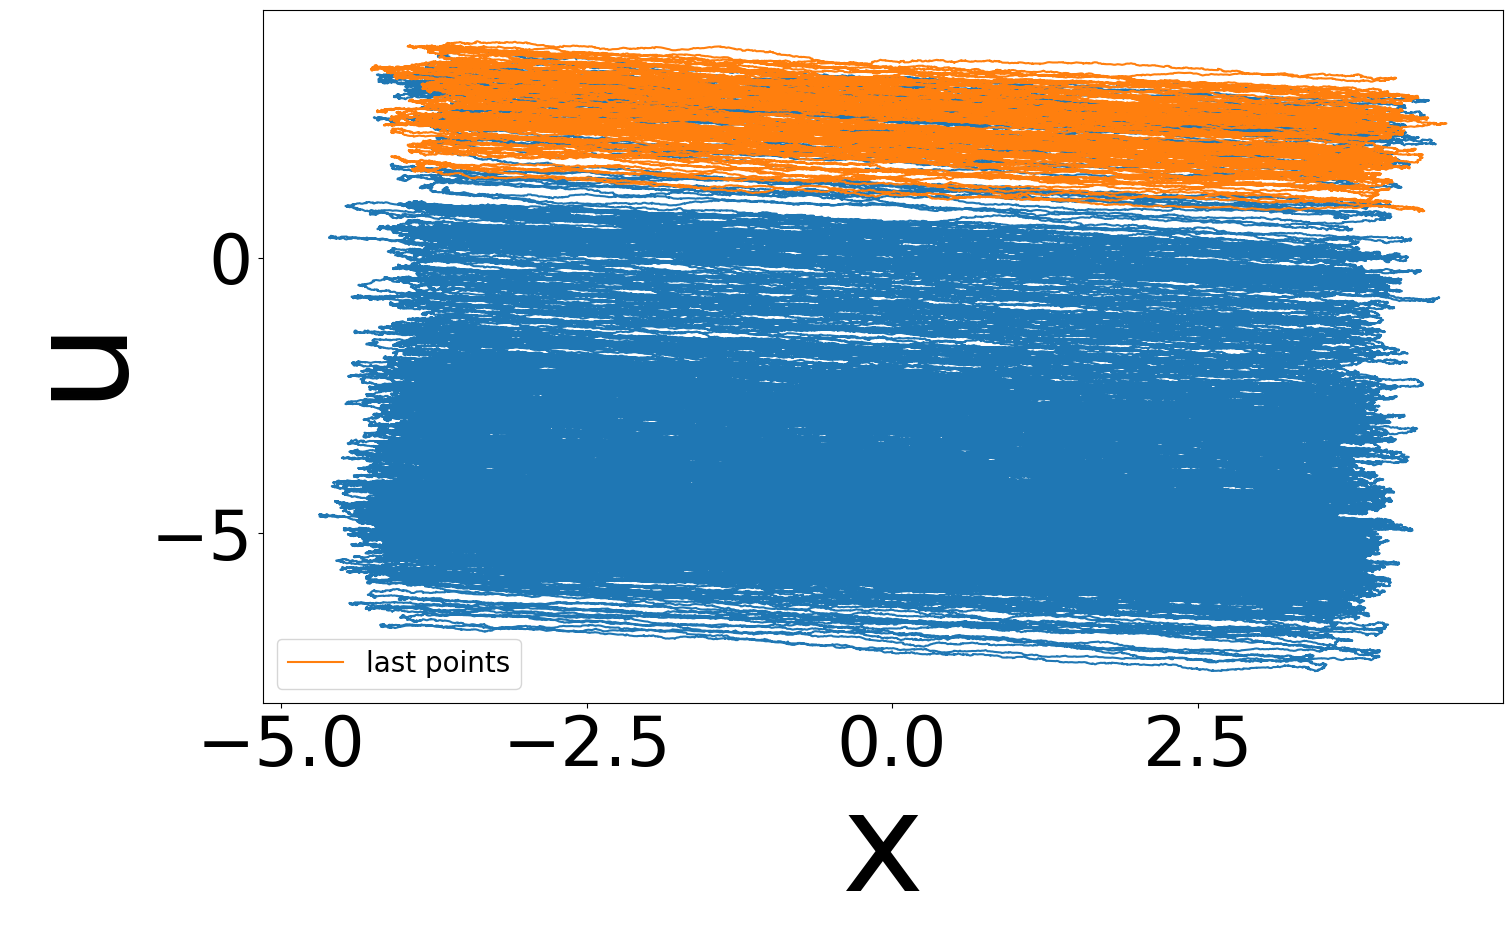

In [26]:
plt.figure(figsize=(16, 9))
plt.plot(noise_train_trajectory[:900000, 0], noise_train_trajectory[:900000, 3])

plt.plot(noise_train_trajectory[900000:, 0], noise_train_trajectory[900000:, 3], label="last points")
plt.xlabel("x", size=100)
plt.ylabel("u", size=100)
plt.tick_params(axis='both', which='major', labelsize=50)
plt.legend(fontsize=20)